# Lecture 2. Linear models
**Basics of modeling, optimization, and regularization**

Joaquin Vanschoren

In [1]:
# Auto-setup when running on Google Colab
import os
if 'google.colab' in str(get_ipython()) and not os.path.exists('/content/master'):
    !git clone -q https://github.com/ML-course/master.git /content/master
    !pip --quiet install -r /content/master/requirements_colab.txt
    %cd master/notebooks

# Global imports and settings
%matplotlib inline
from preamble import *
interactive = True # Set to True for interactive plots
if interactive:
    fig_scale = 0.5
    plt.rcParams.update(print_config)
else: # For printing
    fig_scale = 0.3
    plt.rcParams.update(print_config)

## Notation and Definitions 
* A _scalar_ is a simple numeric value, denoted by an italic letter: $x=3.24$
* A _vector_ is a 1D ordered array of _n_ scalars, denoted by a bold letter: $\mathbf{x}=[3.24, 1.2]$
    * $x_i$ denotes the $i$th element of a vector, thus $x_0 = 3.24$.
        * Note: some other courses use $x^{(i)}$ notation
* A _set_ is an _unordered_ collection of unique elements, denote by caligraphic capital: $\mathcal{S}=\{3.24, 1.2\}$
* A _matrix_ is a 2D array of scalars, denoted by bold capital: $\mathbf{X}=\begin{bmatrix}
3.24 & 1.2 \\
2.24 & 0.2 
\end{bmatrix}$
    * $\textbf{X}_{i}$ denotes the $i$th _row_ of the matrix
    * $\textbf{X}_{:,j}$ denotes the $j$th _column_
    * $\textbf{X}_{i,j}$ denotes the _element_ in the $i$th row, $j$th column, thus $\mathbf{X}_{1,0} = 2.24$

* $\mathbf{X}^{n \times p}$, an $n \times p$ matrix, can represent $n$ data points in a $p$-dimensional space 
    * Every row is a vector that can represent a _point_ in an p-dimensional space, given a _basis_.
    * The _standard basis_ for a Euclidean space is the set of unit vectors
* E.g. if $\mathbf{X}=\begin{bmatrix}
3.24 & 1.2 \\
2.24 & 0.2 \\
3.0 & 0.6 
\end{bmatrix}$

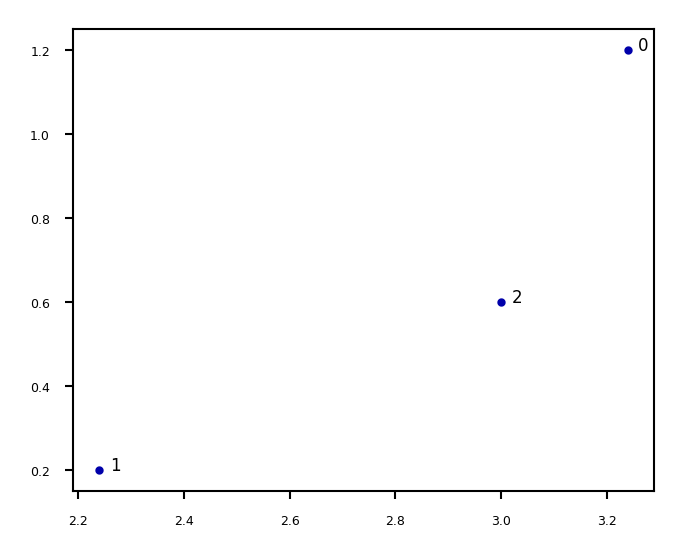

In [2]:
X = np.array([[3.24 , 1.2 ],[2.24, 0.2],[3.0 , 0.6 ]]) 
fig = plt.figure(figsize=(5*fig_scale,4*fig_scale))
plt.scatter(X[:,0],X[:,1]);
for i in range(3):
    plt.annotate(i, (X[i,0]+0.02, X[i,1]))

* A _tensor_ is an _k_-dimensional array of data, denoted by an italic capital: $T$
    * _k_ is also called the order, degree, or rank
    * $T_{i,j,k,...}$ denotes the element or sub-tensor in the corresponding position
    * A set of color images can be represented by:
        * a 4D tensor (sample x height x width x color channel)
        * a 2D tensor (sample x flattened vector of pixel values)
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/08_images.png" alt="ml" style="width: 40%;"/>

### Basic operations
* Sums and products are denoted by capital Sigma and capital Pi:

$$\sum_{i=0}^{p} = x_0 + x_1 + ... + x_p \quad \prod_{i=0}^{p} = x_0 \cdot x_1 \cdot ... \cdot x_p$$

* Operations on vectors are element-wise: e.g. $\mathbf{x}+\mathbf{z} = [x_0+z_0,x_1+z_1, ... , x_p+z_p]$
* Dot product $\mathbf{w}\mathbf{x} = \mathbf{w} \cdot \mathbf{x} = \mathbf{w}^{T} \mathbf{x} = \sum_{i=0}^{p} w_i \cdot x_i = w_0 \cdot x_0 + w_1 \cdot x_1 + ... + w_p \cdot x_p$
* Matrix product $\mathbf{W}\mathbf{x} = \begin{bmatrix}
\mathbf{w_0} \cdot \mathbf{x} \\
... \\
\mathbf{w_p} \cdot \mathbf{x} \end{bmatrix}$
* A function $f(x) = y$ relates an input element $x$ to an output $y$
    * It has a _local minimum_ at $x=c$ if $f(x) \geq f(c)$ in interval $(c-\epsilon, c+\epsilon)$
    * It has a _global minimum_ at $x=c$ if $f(x) \geq f(c)$ for any value for $x$
* A vector function consumes an input and produces a vector: $\mathbf{f}(\mathbf{x}) = \mathbf{y}$
* $\underset{x\in X}{\operatorname{max}}f(x)$ returns the largest value f(x) for any x
* $\underset{x\in X}{\operatorname{argmax}}f(x)$ returns the element x that maximizes f(x)

### Gradients
* A _derivative_ $f'$ of a function $f$ describes how fast $f$ grows or decreases
* The process of finding a derivative is called differentiation
    * Derivatives for basic functions are known
    * For non-basic functions we use the chain rule: $F(x) = f(g(x)) \rightarrow F'(x)=f'(g(x))g'(x)$
* A function is _differentiable_ if it has a derivative in any point of it's domain
    * It's _continuously differentiable_ if $f'$ is a continuous function
    * We say $f$ is _smooth_ if it is _infinitely differentiable_, i.e., $f', f'', f''', ...$ all exist
* A _gradient_ $\nabla f$ is the derivative of a function in multiple dimensions
    * It is a vector of partial derivatives: $\nabla f = \left[ \frac{\partial f}{\partial x_0}, \frac{\partial f}{\partial x_1},... \right]$
    * E.g. $f=2x_0+3x_1^{2}-\sin(x_2) \rightarrow \nabla f= [2, 6x_1, -cos(x_2)]$

* Example: $f = -(x_0^2+x_1^2)$
    * $\nabla f = \left[\frac{\partial f}{\partial x_0},\frac{\partial f}{\partial x_1}\right] = \left[-2x_0,-2x_1\right]$
    * Evaluated at point (-4,1): $\nabla f(-4,1) = [8,-2]$
        * These are the slopes at point (-4,1) in the direction of $x_0$ and $x_1$ respectively

In [3]:
from mpl_toolkits import mplot3d
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# f = -(x0^2 + x1^2)
def g_f(x0, x1):
    return -(x0 ** 2 + x1 ** 2)
def g_dfx0(x0):
    return -2 * x0
def g_dfx1(x1):
    return -2 * x1

@interact
def plot_gradient(rotation=(0,240,10)):
    # plot surface of f
    fig = plt.figure(figsize=(12*fig_scale,5*fig_scale))
    ax = plt.axes(projection="3d")
    x0 = np.linspace(-6, 6, 30)
    x1 = np.linspace(-6, 6, 30)
    X0, X1 = np.meshgrid(x0, x1)
    ax.plot_surface(X0, X1, g_f(X0, X1), rstride=1, cstride=1,
                    cmap='winter', edgecolor='none',alpha=0.3)

    # choose point to evaluate: (-4,1)
    i0 = -4
    i1 = 1
    iz = np.linspace(g_f(i0,i1), -82, 30)
    ax.scatter3D(i0, i1, g_f(i0,i1), c="k", s=20*fig_scale,label='($i_0$,$i_1$) = (-4,1)')
    ax.plot3D([i0]*30, [i1]*30, iz, linewidth=1*fig_scale, c='silver', linestyle='-')
    ax.set_zlim(-80,0)

    # plot intersects
    ax.plot3D(x0,[1]*30,g_f(x0, 1),linewidth=3*fig_scale,alpha=0.9,label='$f(x_0,i_1)$',c='r',linestyle=':')
    ax.plot3D([-4]*30,x1,g_f(-4, x1),linewidth=3*fig_scale,alpha=0.9,label='$f(i_0,x_1)$',c='b',linestyle=':')

    # df/dx0 is slope of line at the intersect point
    x0 = np.linspace(-8, 0, 30)
    ax.plot3D(x0,[1]*30,g_dfx0(i0)*x0-g_f(i0,i1),linewidth=3*fig_scale,label=r'$\frac{\partial f}{\partial x_0}(i_0,i_1) x_0 + f(i_0,i_1)$',c='r',linestyle='-')
    ax.plot3D([-4]*30,x1,g_dfx1(i1)*x1+g_f(i0,i1),linewidth=3*fig_scale,label=r'$\frac{\partial f}{\partial x_1}(i_0,i_1) x_1 + f(i_0,i_1)$',c='b',linestyle='-')

    ax.set_xlabel('x0', labelpad=-4/fig_scale)
    ax.set_ylabel('x1', labelpad=-4/fig_scale)
    ax.get_zaxis().set_ticks([])
    ax.view_init(30, rotation) # Use this to rotate the figure
    ax.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.tick_params(axis='both', width=0, labelsize=10*fig_scale, pad=-6)

    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=120, description='rotation', max=240, step=10), Output()), _dom_classes=…

In [4]:
if not interactive:
    plot_gradient(rotation=120)

### Distributions and Probabilities
* The normal (Gaussian) distribution with mean $\mu$ and standard deviation $\sigma$ is noted as $N(\mu,\sigma)$
* A random variable $X$ can be continuous or discrete
* A probability distribution $f_X$ of a continuous variable $X$: _probability density function_ (pdf)
    * The _expectation_ is given by $\mathbb{E}[X] = \int x f_{X}(x) dx$
* A probability distribution of a discrete variable: _probability mass function_ (pmf)
    * The _expectation_ (or mean) $\mu_X = \mathbb{E}[X] = \sum_{i=1}^k[x_i \cdot Pr(X=x_i)]$
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/02_pdf.png" alt="ml" style="width: 70%;"/>

# Linear models
Linear models make a prediction using a linear function of the input features $X$ 

$$f_{\mathbf{w}}(\mathbf{x}) = \sum_{i=1}^{p} w_i \cdot x_i + w_{0}$$

Learn $w$ from $X$, given a loss function $\mathcal{L}$:

$$\underset{\mathbf{w}}{\operatorname{argmin}} \mathcal{L}(f_\mathbf{w}(X))$$

* Many algorithms with different $\mathcal{L}$: Least squares, Ridge, Lasso, Logistic Regression, Linear SVMs,...
* Can be very powerful (and fast), especially for large datasets with many features.
* Can be generalized to learn non-linear patterns: _Generalized Linear Models_
    * Features can be augmentented with polynomials of the original features
    * Features can be transformed according to a distribution (Poisson, Tweedie, Gamma,...)
    * Some linear models (e.g. SVMs) can be _kernelized_ to learn non-linear functions

## Linear models for regression
* Prediction formula for input features x:
    * $w_1$ ... $w_p$ usually called _weights_ or _coefficients_ , $w_0$ the _bias_ or _intercept_
    * Assumes that errors are $N(0,\sigma)$

$$\hat{y} = \mathbf{w}\mathbf{x} + w_0 = \sum_{i=1}^{p} w_i \cdot x_i + w_0 = w_1 \cdot x_1 + w_2 \cdot x_2 + ... + w_p \cdot x_p + w_0 $$

w_1: 0.393906  w_0: -0.031804


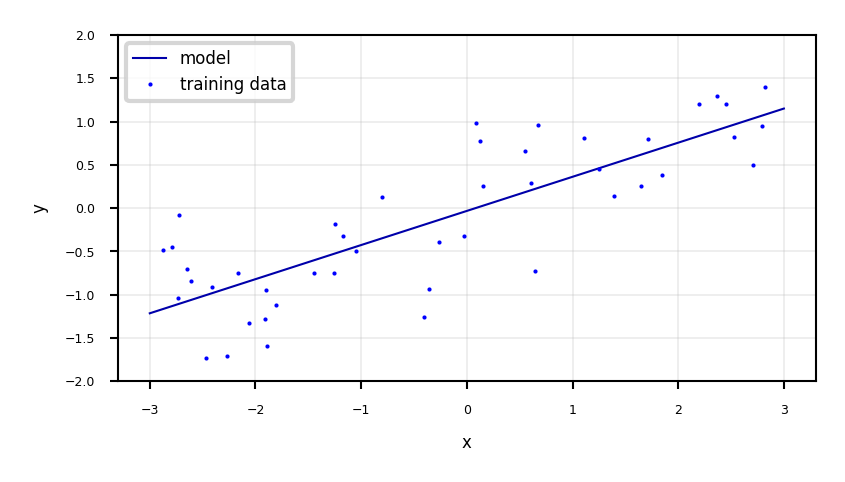

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from mglearn.datasets import make_wave

Xw, yw = make_wave(n_samples=60)
Xw_train, Xw_test, yw_train, yw_test = train_test_split(Xw, yw, random_state=42)

line = np.linspace(-3, 3, 100).reshape(-1, 1)

lr = LinearRegression().fit(Xw_train, yw_train)
print("w_1: %f  w_0: %f" % (lr.coef_[0], lr.intercept_))

plt.figure(figsize=(6*fig_scale, 3*fig_scale))
plt.plot(line, lr.predict(line), lw=fig_scale)
plt.plot(Xw_train, yw_train, 'o', c='b')
#plt.plot(X_test, y_test, '.', c='r')
ax = plt.gca()
ax.grid(True)
ax.set_ylim(-2, 2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(["model", "training data"], loc="best");

### Linear Regression (aka Ordinary Least Squares)
* Loss function is the _sum of squared errors_ (SSE) (or residuals) between predictions $\hat{y}_i$ (red) and the true regression targets $y_i$ (blue) on the training set.

$$\mathcal{L}_{SSE} = \sum_{n=1}^{N} (y_n-\hat{y}_n)^2 = \sum_{n=1}^{N} (y_n-(\mathbf{w}\mathbf{x_n} + w_0))^2$$ 

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/02_least_squares.png" alt="ml" style="margin: 0 auto; width: 750px;"/>

#### Solving ordinary least squares
* Convex optimization problem with unique closed-form solution:
    
    $$w^{*} = (X^{T}X)^{-1} X^T Y$$
    
    * Add a column of 1's to the front of X to get $w_0$
    * Slow. Time complexity is quadratic in number of features: $\mathcal{O}(p^2n)$
        * X has $n$ rows, $p$ features, hence $X^{T}X$ has dimensionality $p \cdot p$
    * Only works if $n>p$
* _Gradient Descent_
    * Faster for large and/or high-dimensional datasets
    * When $X^{T}X$ cannot be computed or takes too long ($p$ or $n$ is too large)
    * When you want more control over the learning process
* **Very easily overfits**.
    * coefficients $w$ become very large (steep incline/decline)
    * small change in the input *x* results in a very different output *y* 
    * No hyperparameters that control model complexity

#### Gradient Descent
* Start with an initial, random set of weights: $\mathbf{w}^0$
* Given a differentiable loss function $\mathcal{L}$ (e.g. $\mathcal{L}_{SSE}$), compute $\nabla \mathcal{L}$
* For least squares: $\frac{\partial \mathcal{L}_{SSE}}{\partial w_i}(\mathbf{w}) = -2\sum_{n=1}^{N} (y_n-\hat{y}_n) x_{n,i}$
    * If feature $X_{:,i}$ is associated with big errors, the gradient wrt $w_i$ will be large
* Update _all_ weights slightly (by _step size_ or _learning rate_ $\eta$) in 'downhill' direction.
* Basic _update rule_ (step s): 

    $$\mathbf{w}^{s+1} = \mathbf{w}^s-\eta\nabla \mathcal{L}(\mathbf{w}^s)$$

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/01_gradient_descent.jpg" alt="ml" style="width: 700px;"/>

* Important hyperparameters
    * Learning rate
        * Too small: slow convergence. Too large: possible divergence
    * Maximum number of iterations
        * Too small: no convergence. Too large: wastes resources
    * Learning rate decay with decay rate $k$
        * E.g. exponential ($\eta^{s+1} = \eta^{0}  e^{-ks}$), inverse-time ($\eta^{s+1} = \frac{\eta^{s}}{1+ks}$),...
    * Many more advanced ways to control learning rate (see later)
        * Adaptive techniques: depend on how much loss improved in previous step

interactive(children=(FloatSlider(value=0.2, description='learn_rate', max=0.4, min=0.01, step=0.01), Checkbox…

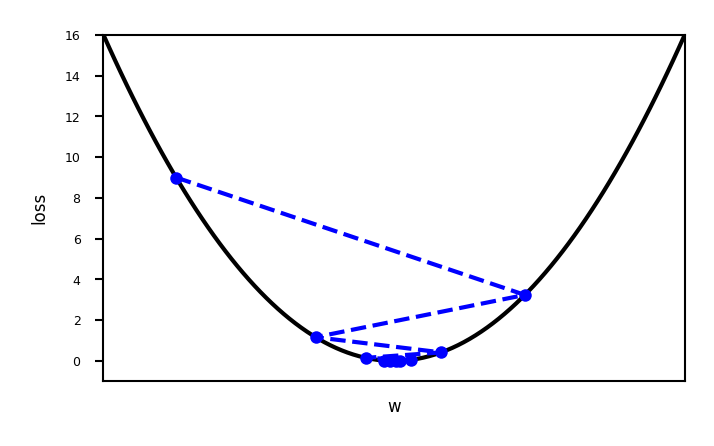

In [6]:
import math
# Some convex function to represent the loss
def l_fx(x):
    return (x * 4)**2 
# Derivative to compute the gradient
def l_dfx0(x0):
    return 8 * x0

@interact
def plot_learning_rate(learn_rate=(0.01,0.4,0.01), exp_decay=False):
    w = np.linspace(-1,1,101)
    f = [l_fx(i) for i in w]
    w_current = -0.75
    learn_rate_current = learn_rate
    fw = [] # weight values
    fl = [] # loss values
    for i in range(10):
        fw.append(w_current)
        fl.append(l_fx(w_current))
        # Decay
        if exp_decay:
            learn_rate_current = learn_rate * math.exp(-0.3*i)
        # Update rule
        w_current = w_current - learn_rate_current * l_dfx0(w_current)
    fig, ax = plt.subplots(figsize=(5*fig_scale,3*fig_scale))
    ax.set_xlabel('w')
    ax.set_xticks([])
    ax.set_ylabel('loss')
    ax.plot(w, f, lw=2*fig_scale, ls='-', c='k', label='Loss')
    ax.plot(fw, fl, '--bo', lw=2*fig_scale, markersize=3)
    plt.ylim(-1,16)
    plt.xlim(-1,1)

In [7]:
if not interactive:
    plot_learning_rate(learn_rate=0.21, exp_decay=False)

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Toy surface
def f(x, y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

# TensorFlow optimizers
sgd = tf.optimizers.SGD(learning_rate=0.01)
lr_schedule = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.02,
    decay_steps=100,
    decay_rate=0.96
)
sgd_decay = tf.optimizers.SGD(learning_rate=lr_schedule)

optimizers = [sgd, sgd_decay]
opt_names = ['sgd', 'sgd_decay']
cmap = plt.cm.get_cmap('tab10')
colors = [cmap(x/10) for x in range(10)]

# Training
all_paths = []
for opt, name in zip(optimizers, opt_names):
    x = tf.Variable(0.8, dtype=tf.float32)
    y = tf.Variable(1.6, dtype=tf.float32)

    x_history = []
    y_history = []
    loss_prev = 0.0
    max_steps = 100
    
    for step in range(max_steps):
        with tf.GradientTape() as g:
            loss = f(x, y)
        
        x_history.append(x.numpy())
        y_history.append(y.numpy())
        grads = g.gradient(loss, [x, y])
        opt.apply_gradients(zip(grads, [x, y]))
        
        if np.abs(loss_prev - loss.numpy()) < 1e-6:
            break
        loss_prev = loss.numpy()
    
    x_history = np.array(x_history)
    y_history = np.array(y_history)
    path = np.vstack((x_history, y_history))
    all_paths.append(path)

In [9]:
from matplotlib.colors import LogNorm

# Toy surface
def f(x, y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

# Tensorflow optimizers
sgd = tf.optimizers.SGD(0.01)
lr_schedule = tf.optimizers.schedules.ExponentialDecay(0.02,decay_steps=100,decay_rate=0.96)
sgd_decay = tf.optimizers.SGD(learning_rate=lr_schedule)

optimizers = [sgd, sgd_decay]
opt_names = ['sgd', 'sgd_decay']
cmap = plt.cm.get_cmap('tab10')
colors = [cmap(x/10) for x in range(10)]

# Training
all_paths = []
for opt, name in zip(optimizers, opt_names):
    x_init = 0.8
    x = tf.Variable(x_init)
    y_init = 1.6
    y = tf.Variable(y_init)

    x_history = []
    y_history = []
    z_prev = 0.0
    max_steps = 100
    for step in range(max_steps):
        with tf.GradientTape() as g:
            z = f(x, y)
            x_history.append(x.numpy())
            y_history.append(y.numpy())
            dz_dx, dz_dy = g.gradient(z, [x, y])
            opt.apply_gradients(zip([dz_dx, dz_dy], [x, y]))

    if np.abs(z_prev - z.numpy()) < 1e-6:
        break
    z_prev = z.numpy()
    x_history = np.array(x_history)
    y_history = np.array(y_history)
    path = np.concatenate((np.expand_dims(x_history, 1), np.expand_dims(y_history, 1)), axis=1).T
    all_paths.append(path)
        
# Plotting
number_of_points = 50
margin = 4.5
minima = np.array([3., .5])
minima_ = minima.reshape(-1, 1)
x_min = 0. - 2
x_max = 0. + 3.5
y_min = 0. - 3.5
y_max = 0. + 2
x_points = np.linspace(x_min, x_max, number_of_points) 
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([f(xps, yps) for xps, yps in zip(x_mesh, y_mesh)])

def plot_optimizers(ax, iterations, optimizers):
    ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-0.5, 5, 25), norm=LogNorm(), cmap=plt.cm.jet, linewidths=fig_scale, zorder=-1)
    ax.plot(*minima, 'r*', markersize=20*fig_scale)
    for name, path, color in zip(opt_names, all_paths, colors):
        if name in optimizers:
            p = path[:,:iterations]
            ax.plot([], [], color=color, label=name, lw=3*fig_scale, linestyle='-')
            ax.quiver(p[0,:-1], p[1,:-1], p[0,1:]-p[0,:-1], p[1,1:]-p[1,:-1], scale_units='xy', angles='xy', scale=1, color=color, lw=4)


    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))
    ax.legend(loc='lower left', prop={'size': 15*fig_scale}) 
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

In [10]:
from matplotlib.colors import LogNorm

# Training for momentum
all_lr_paths = []
lr_range = [0.005 * i for i in range(10)]

for lr in lr_range:
    opt = tf.optimizers.SGD(learning_rate=lr, nesterov=False)
    
    x = tf.Variable(0.8, dtype=tf.float32)
    y = tf.Variable(1.6, dtype=tf.float32)
    
    x_history = []
    y_history = []
    z_prev = 0.0
    max_steps = 100
    
    for step in range(max_steps):
        with tf.GradientTape() as g:
            z = f(x, y)
        
        x_history.append(x.numpy())
        y_history.append(y.numpy())
        dz_dx, dz_dy = g.gradient(z, [x, y])
        opt.apply_gradients(zip([dz_dx, dz_dy], [x, y]))
        
        if np.abs(z_prev - z.numpy()) < 1e-6:
            break
        z_prev = z.numpy()
    
    x_history = np.array(x_history)
    y_history = np.array(y_history)
    path = np.vstack((x_history, y_history))
    all_lr_paths.append(path)
    
# Plotting
number_of_points = 50
margin = 4.5
minima = np.array([3., 0.5])
minima_ = minima.reshape(-1, 1)
x_min = -2
x_max = 3.5
y_min = -3.5
y_max = 2
x_points = np.linspace(x_min, x_max, number_of_points) 
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([[f(xps, yps) for xps, yps in zip(row_x, row_y)] for row_x, row_y in zip(x_mesh, y_mesh)])

def plot_learning_rate_optimizers(ax, iterations, lr):
    ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-0.5, 5, 25), norm=LogNorm(), cmap=plt.cm.jet, linewidths=1, zorder=-1)
    ax.plot(*minima, 'r*', markersize=20)
    
    for path, lrate in zip(all_lr_paths, lr_range):
        if round(lrate, 3) == lr:
            p = path[:, :iterations]
            ax.plot([], [], color='b', label=f"Learning rate {lr}", lw=3, linestyle='-')
            ax.quiver(p[0, :-1], p[1, :-1], p[0, 1:] - p[0, :-1], p[1, 1:] - p[1, :-1], scale_units='xy', angles='xy', scale=1, color='b', lw=4)
    
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))
    ax.legend(loc='lower left', prop={'size': 8})
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

**Effect of learning rate**

In [11]:
@interact
def plot_lr(iterations=(1, 100, 1), learning_rate=(0.005, 0.045, 0.005)):  # Fixed range
    fig, ax = plt.subplots(figsize=(6 * fig_scale, 4 * fig_scale))
    plot_learning_rate_optimizers(ax, iterations, learning_rate)
    plt.show()
    
if not interactive:
    plot_lr(iterations=50, learning_rate=0.02)

interactive(children=(IntSlider(value=50, description='iterations', min=1), FloatSlider(value=0.025, descripti…

**Effect of learning rate decay**

interactive(children=(IntSlider(value=50, description='iterations', min=1), Dropdown(description='optimizer1',…

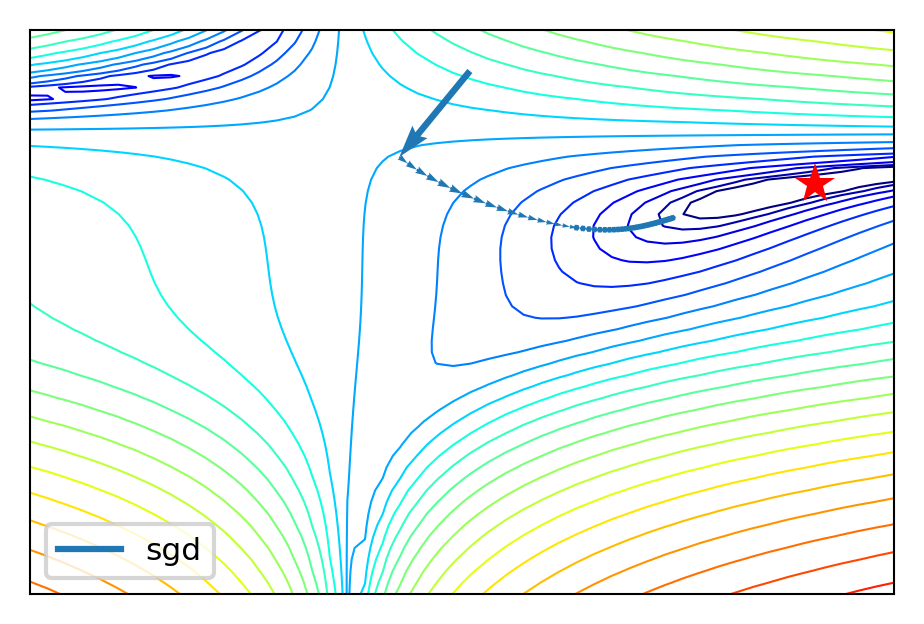

In [12]:
@interact
def compare_optimizers(iterations=(1,100,1), optimizer1=opt_names, optimizer2=opt_names):
    fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
    plot_optimizers(ax,iterations,[optimizer1,optimizer2])
    
if not interactive:
    compare_optimizers(iterations=50, optimizer1="sgd", optimizer2="sgd_decay")

In two dimensions:
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/01_gradient_descent_2D.png" alt="ml" style="width: 900px;"/>

* You can get stuck in local minima (if the loss is not fully convex)
    * If you have many model parameters, this is less likely
    * You always find a way down in some direction
    * Models with many parameters typically find good local minima

* Intuition: walking downhill using only the slope you "feel" nearby

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/01_gradient_descent_hill.png" alt="ml" style="width: 1200px;"/>

(Image by A. Karpathy)

#### Stochastic Gradient Descent (SGD)
* Compute gradients not on the entire dataset, but on a single data point $i$ at a time
    * Gradient descent: $\mathbf{w}^{s+1} = \mathbf{w}^s-\eta\nabla \mathcal{L}(\mathbf{w}^s) = \mathbf{w}^s-\frac{\eta}{n} \sum_{i=1}^{n} \nabla \mathcal{L_i}(\mathbf{w}^s)$
    * Stochastic Gradient Descent: $\mathbf{w}^{s+1} = \mathbf{w}^s-\eta\nabla \mathcal{L_i}(\mathbf{w}^s)$
* Many smoother variants, e.g.
    * Minibatch SGD: compute gradient on batches of data: $\mathbf{w}^{s+1} = \mathbf{w}^s-\frac{\eta}{B} \sum_{i=1}^{B} \nabla \mathcal{L_i}(\mathbf{w}^s)$
    * Stochastic Average Gradient Descent ([SAG](https://link.springer.com/content/pdf/10.1007/s10107-016-1030-6.pdf), [SAGA](https://proceedings.neurips.cc/paper/2014/file/ede7e2b6d13a41ddf9f4bdef84fdc737-Paper.pdf)). With $i_s \in [1,n]$ randomly chosen per iteration:
        * Incremental gradient: $\mathbf{w}^{s+1} = \mathbf{w}^s-\frac{\eta}{n} \sum_{i=1}^{n} v_i^s$ with $v_i^s = \begin{cases}\nabla \mathcal{L_i}(\mathbf{w}^s) & i = i_s \\ v_i^{s-1} & \text{otherwise} \end{cases}$
        
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/08_SGD.png" alt="ml" style="float: left; width: 600px;"/>

#### In practice
* Linear regression can be found in `sklearn.linear_model`. We'll evaluate it on the Boston Housing dataset.
    * `LinearRegression` uses closed form solution, `SGDRegressor` with `loss='squared_loss'` uses Stochastic Gradient Descent
    * Large coefficients signal overfitting
    * Test score is much lower than training score

``` python
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)
```

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_B, y_B = mglearn.datasets.load_extended_boston()
X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(X_B, y_B, random_state=0)

lr = LinearRegression().fit(X_B_train, y_B_train)

In [14]:
print("Weights (coefficients): {}".format(lr.coef_[0:40]))
print("Bias (intercept): {}".format(lr.intercept_))

Weights (coefficients): [ -412.711   -52.243  -131.899   -12.004   -15.511    28.716    54.704
   -49.535    26.582    37.062   -11.828   -18.058   -19.525    12.203
  2980.781  1500.843   114.187   -16.97     40.961   -24.264    57.616
  1278.121 -2239.869   222.825    -2.182    42.996   -13.398   -19.389
    -2.575   -81.013     9.66      4.914    -0.812    -7.647    33.784
   -11.446    68.508   -17.375    42.813     1.14 ]
Bias (intercept): 30.93456367364179


In [15]:
print("Training set score (R^2): {:.2f}".format(lr.score(X_B_train, y_B_train)))
print("Test set score (R^2): {:.2f}".format(lr.score(X_B_test, y_B_test)))

Training set score (R^2): 0.95
Test set score (R^2): 0.61



### Ridge regression
* Adds a penalty term to the least squares loss function:

$$\mathcal{L}_{Ridge} = \sum_{n=1}^{N} (y_n-(\mathbf{w}\mathbf{x_n} + w_0))^2 + \alpha \sum_{i=1}^{p} w_i^2$$ 

* Model is penalized if it uses large coefficients ($w$)
    * Each feature should have as little effect on the outcome as possible 
    * We don't want to penalize $w_0$, so we leave it out
* Regularization: explicitly restrict a model to avoid overfitting. 
    * Called L2 regularization because it uses the L2 norm: $\sum w_i^2$
* The strength of the regularization can be controlled with the $\alpha$ hyperparameter.
    * Increasing $\alpha$ causes more regularization (or shrinkage). Default is 1.0.
* Still convex. Can be optimized in different ways:
    * Closed form solution (a.k.a. Cholesky): $w^{*} = (X^{T}X + \alpha I)^{-1} X^T Y$
    * Gradient descent and variants, e.g. Stochastic Average Gradient (SAG,SAGA)
        * Conjugate gradient (CG): each new gradient is influenced by previous ones
    * Use Cholesky for smaller datasets, Gradient descent for larger ones
   

#### In practice
``` python
from sklearn.linear_model import Ridge
lr = Ridge().fit(X_train, y_train)
```

In [16]:
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_B_train, y_B_train)
print("Weights (coefficients): {}".format(ridge.coef_[0:40]))
print("Bias (intercept): {}".format(ridge.intercept_))
print("Training set score: {:.2f}".format(ridge.score(X_B_train, y_B_train)))
print("Test set score: {:.2f}".format(ridge.score(X_B_test, y_B_test)))

Weights (coefficients): [-1.414 -1.557 -1.465 -0.127 -0.079  8.332  0.255 -4.941  3.899 -1.059
 -1.584  1.051 -4.012  0.334  0.004 -0.849  0.745 -1.431 -1.63  -1.405
 -0.045 -1.746 -1.467 -1.332 -1.692 -0.506  2.622 -2.092  0.195 -0.275
  5.113 -1.671 -0.098  0.634 -0.61   0.04  -1.277 -2.913  3.395  0.792]
Bias (intercept): 21.39052595861006
Training set score: 0.89
Test set score: 0.75


Test set score is higher and training set score lower: less overfitting!

* We can plot the weight values for differents levels of regularization to explore the effect of $\alpha$.
* Increasing regularization decreases the values of the coefficients, but never to 0.

interactive(children=(FloatSlider(value=5.0, description='alpha', max=10.0, step=0.05), Output()), _dom_classe…

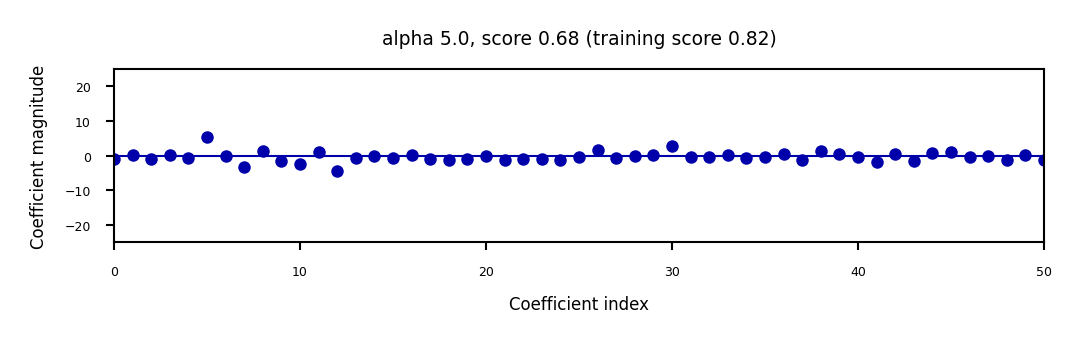

In [17]:
from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from sklearn.linear_model import Ridge

@interact
def plot_ridge(alpha=(0,10.0,0.05)):
    r = Ridge(alpha=alpha).fit(X_B_train, y_B_train)
    fig, ax = plt.subplots(figsize=(8*fig_scale,1.5*fig_scale))
    ax.plot(r.coef_, 'o', markersize=3)
    ax.set_title("alpha {}, score {:.2f} (training score {:.2f})".format(alpha, r.score(X_B_test, y_B_test), r.score(X_B_train, y_B_train)))
    ax.set_xlabel("Coefficient index")
    ax.set_ylabel("Coefficient magnitude")
    ax.hlines(0, 0, len(r.coef_))
    ax.set_ylim(-25, 25)
    ax.set_xlim(0, 50);

In [18]:
if not interactive:
    for alpha in [0.1, 10]:
        plot_ridge(alpha)

* When we plot the train and test scores for every $\alpha$ value, we see a sweet spot around $\alpha=0.2$
    * Models with smaller $\alpha$ are overfitting
    * Models with larger $\alpha$ are underfitting

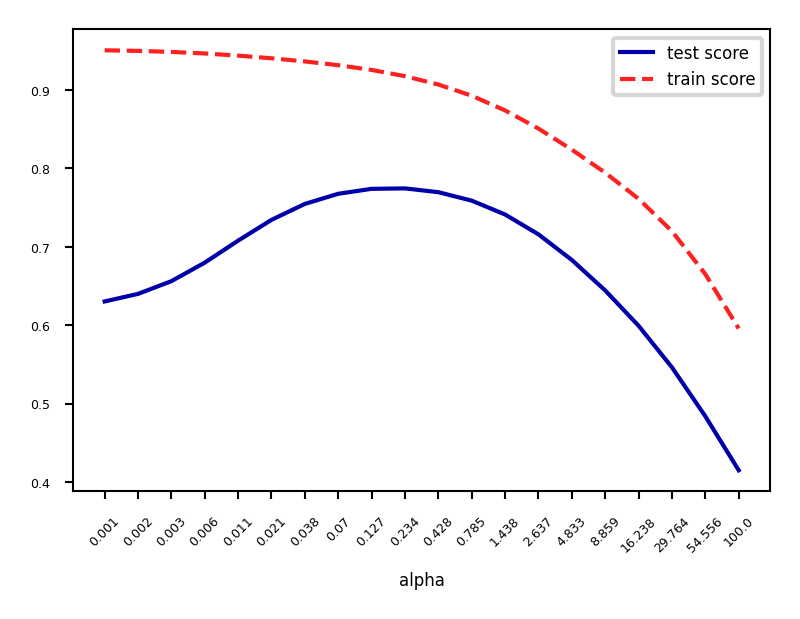

In [19]:
alpha=np.logspace(-3,2,num=20)
ai = list(range(len(alpha)))
test_score=[]
train_score=[]
for a in alpha:
    r = Ridge(alpha=a).fit(X_B_train, y_B_train)
    test_score.append(r.score(X_B_test, y_B_test))
    train_score.append(r.score(X_B_train, y_B_train))
fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
ax.set_xticks(range(20))
ax.set_xticklabels(np.round(alpha,3))
ax.set_xlabel('alpha')
ax.plot(test_score, lw=2*fig_scale, label='test score')
ax.plot(train_score, lw=2*fig_scale, label='train score')
ax.legend()
plt.xticks(rotation=45);

### Other ways to reduce overfitting
* Add more training data: with enough training data, regularization becomes less important
    * Ridge and ordinary least squares will have the same performance
* Use fewer features: remove unimportant ones or find a low-dimensional embedding (e.g. PCA)
    * Fewer coefficients to learn, reduces the flexibility of the model
* Scaling the data typically helps (and changes the optimal $\alpha$ value)

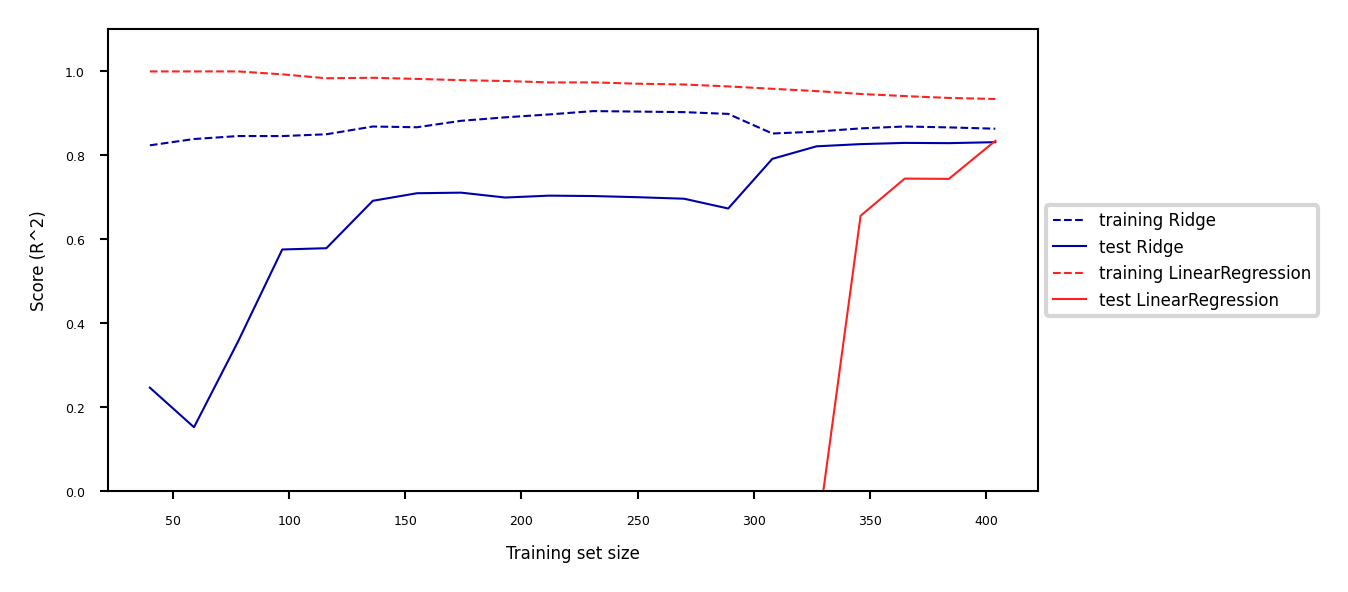

In [20]:
fig, ax = plt.subplots(figsize=(10*fig_scale,4*fig_scale))
mglearn.plots.plot_ridge_n_samples(ax)

### Lasso (Least Absolute Shrinkage and Selection Operator)
* Adds a different penalty term to the least squares sum:

$$\mathcal{L}_{Lasso} = \sum_{n=1}^{N} (y_n-(\mathbf{w}\mathbf{x_n} + w_0))^2 + \alpha \sum_{i=1}^{p} |w_i|$$

* Called L1 regularization because it uses the L1 norm
    * Will cause many weights to be exactly 0
* Same parameter $\alpha$ to control the strength of regularization. 
    * Will again have a 'sweet spot' depending on the data
* No closed-form solution
* Convex, but no longer strictly convex, and not differentiable
    * Weights can be optimized using _coordinate descent_

Analyze what happens to the weights:
* L1 prefers coefficients to be exactly zero (sparse models)
* Some features are ignored entirely: automatic feature selection
* How can we explain this?

interactive(children=(FloatSlider(value=0.25, description='alpha', max=0.5, step=0.005), Output()), _dom_class…

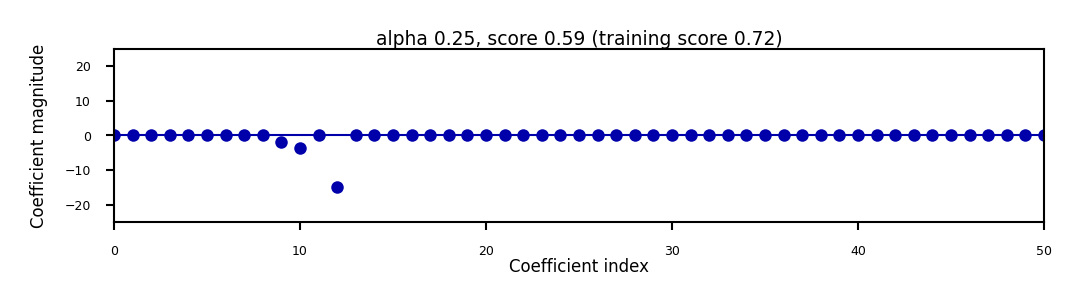

In [21]:
from sklearn.linear_model import Lasso

@interact
def plot_lasso(alpha=(0,0.5,0.005)):
    r = Lasso(alpha=alpha).fit(X_B_train, y_B_train)
    fig, ax = plt.subplots(figsize=(8*fig_scale,1.5*fig_scale))
    ax.plot(r.coef_, 'o', markersize=6*fig_scale)
    ax.set_title("alpha {}, score {:.2f} (training score {:.2f})".format(alpha, r.score(X_B_test, y_B_test), r.score(X_B_train, y_B_train)), pad=0.5)
    ax.set_xlabel("Coefficient index", labelpad=0)
    ax.set_ylabel("Coefficient magnitude")
    ax.hlines(0, 0, len(r.coef_))
    ax.set_ylim(-25, 25);
    ax.set_xlim(0, 50);

In [22]:
if not interactive:
    for alpha in [0.00001, 0.01]:
        plot_lasso(alpha)

#### Coordinate descent
- Alternative for gradient descent, supports non-differentiable convex loss functions (e.g. $\mathcal{L}_{Lasso}$)
- In every iteration, optimize a single coordinate $w_i$ (find minimum in direction of $x_i$)
    - Continue with another coordinate, using a selection rule (e.g. round robin)
- Faster iterations. No need to choose a step size (learning rate).
- May converge more slowly. Can't be parallellized.

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/02_cd.png" alt="ml" style="width: 700px;"/>

#### Coordinate descent with Lasso

- Remember that $\mathcal{L}_{Lasso} = \mathcal{L}_{SSE} + \alpha \sum_{i=1}^{p} |w_i|$ 
- For one $w_i$: $\mathcal{L}_{Lasso}(w_i) = \mathcal{L}_{SSE}(w_i) + \alpha |w_i|$
- The L1 term is not differentiable but convex: we can compute the [_subgradient_](https://towardsdatascience.com/unboxing-lasso-regularization-with-proximal-gradient-method-ista-iterative-soft-thresholding-b0797f05f8ea) 
    - Unique at points where $\mathcal{L}$ is differentiable, a range of all possible slopes [a,b] where it is not
    - For $|w_i|$, the subgradient $\partial_{w_i} |w_i|$ =  $\begin{cases}-1 & w_i<0\\ [-1,1] & w_i=0 \\ 1 & w_i>0 \\ \end{cases}$

    - Subdifferential $\partial(f+g) = \partial f + \partial g$ if $f$ and $g$ are both convex
- To find the optimum for Lasso $w_i^{*}$, solve

    $$\begin{aligned} \partial_{w_i} \mathcal{L}_{Lasso}(w_i) &= \partial_{w_i} \mathcal{L}_{SSE}(w_i) + \partial_{w_i} \alpha |w_i| \\ 0 &= (w_i - \rho_i) + \alpha \cdot \partial_{w_i} |w_i| \\ w_i &= \rho_i - \alpha \cdot \partial_{w_i} |w_i| \end{aligned}$$

    - In which $\rho_i$ is the part of $\partial_{w_i} \mathcal{L}_{SSE}(w_i)$ excluding $w_i$ (assume $z_i=1$ for now)
        - $\rho_i$ can be seen as the $\mathcal{L}_{SSE}$ 'solution': $w_i = \rho_i$ if $\partial_{w_i} \mathcal{L}_{SSE}(w_i) = 0$ 
  $$\partial_{w_i} \mathcal{L}_{SSE}(w_i) = \partial_{w_i} \sum_{n=1}^{N} (y_n-(\mathbf{w}\mathbf{x_n} + w_0))^2 = z_i w_i -\rho_i $$ 

- We found: $w_i = \rho_i - \alpha \cdot \partial_{w_i} |w_i|$
- [The Lasso solution](https://xavierbourretsicotte.github.io/lasso_derivation.html) has the form of a _soft thresholding function_ $S$

    $$w_i^* = S(\rho_i,\alpha) = \begin{cases} \rho_i + \alpha, & \rho_i < -\alpha \\  0, & -\alpha < \rho_i < \alpha \\ \rho_i - \alpha, & \rho_i > \alpha \\ \end{cases}$$
    
    - Small weights become 0: sparseness!
    - If the data is not normalized, $w_i^* = \frac{1}{z_i}S(\rho_i,\alpha)$ with constant $z_i = \sum_{n=1}^{N} x_{ni}^2$
- Ridge solution: $w_i = \rho_i - \alpha \cdot \partial_{w_i} w_i^2 = \rho_i - 2\alpha \cdot w_i$, thus $w_i^* = \frac{\rho_i}{1 + 2\alpha}$

interactive(children=(FloatSlider(value=1.0, description='alpha', max=2.0, step=0.05), Output()), _dom_classes…

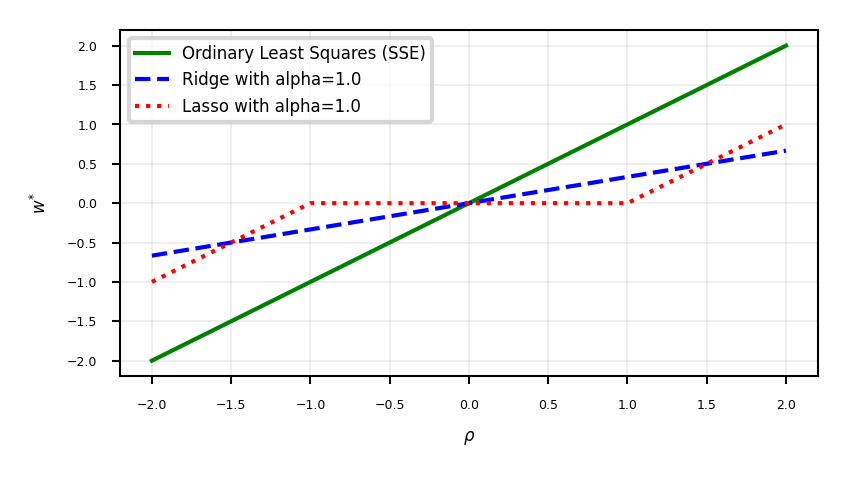

In [23]:
@interact
def plot_rho(alpha=(0,2.0,0.05)):
    w = np.linspace(-2,2,101)
    r = w/(1+2*alpha)
    l = [x+alpha if x <= -alpha else (x-alpha if x > alpha else 0) for x in w]
    fig, ax = plt.subplots(figsize=(6*fig_scale,3*fig_scale))
    ax.set_xlabel(r'$\rho$')
    ax.set_ylabel(r'$w^{*}$')
    ax.plot(w, w, lw=2*fig_scale, c='g', label='Ordinary Least Squares (SSE)')
    ax.plot(w, r, lw=2*fig_scale, c='b', label='Ridge with alpha={}'.format(alpha))
    ax.plot(w, l, lw=2*fig_scale, c='r', label='Lasso with alpha={}'.format(alpha))
    ax.legend()
    plt.grid()

In [24]:
if not interactive:
    plot_rho(alpha=1)

### Interpreting L1 and L2 loss
- L1 and L2 in function of the weights

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/L12_1.png" alt="ml" style="width: 900px;"/>

Least Squares Loss + L1 or L2
- Lasso is not differentiable at point 0
- For any minimum of least squares, L2 will be smaller, and L1 is more likely be 0

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

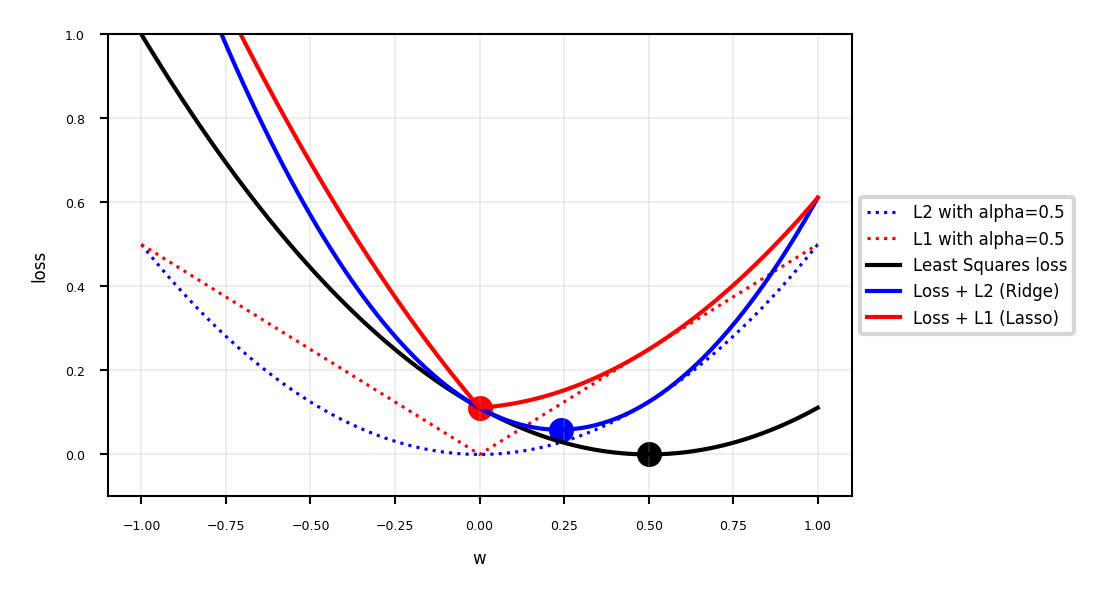

In [25]:
def c_fx(x):
    fX = ((x * 2 - 1)**2) # Some convex function to represent the loss
    return fX/9 # Scaling
def c_fl2(x,alpha):
    return c_fx(x) + alpha * x**2
def c_fl1(x,alpha):
    return c_fx(x) + alpha * abs(x)
def l2(x,alpha):
    return alpha * x**2
def l1(x,alpha):
    return alpha * abs(x)

@interact
def plot_losses(alpha=(0,1.0,0.05)):
    w = np.linspace(-1,1,101)
    f = [c_fx(i) for i in w]
    r = [c_fl2(i,alpha) for i in w]
    l = [c_fl1(i,alpha) for i in w]
    rp = [l2(i,alpha) for i in w]
    lp = [l1(i,alpha) for i in w]
    fig, ax = plt.subplots(figsize=(8*fig_scale,4*fig_scale))
    ax.set_xlabel('w')
    ax.set_ylabel('loss')
    ax.plot(w, rp, lw=1.5*fig_scale, ls=':', c='b', label='L2 with alpha={}'.format(alpha))
    ax.plot(w, lp, lw=1.5*fig_scale, ls=':', c='r', label='L1 with alpha={}'.format(alpha))
    ax.plot(w, f, lw=2*fig_scale, ls='-', c='k', label='Least Squares loss')
    ax.plot(w, r, lw=2*fig_scale, ls='-', c='b', label='Loss + L2 (Ridge)'.format(alpha))
    ax.plot(w, l, lw=2*fig_scale, ls='-', c='r', label='Loss + L1 (Lasso)'.format(alpha))
    opt_f = np.argmin(f)
    ax.scatter(w[opt_f], f[opt_f], c="k", s=50*fig_scale)
    opt_r = np.argmin(r)
    ax.scatter(w[opt_r], r[opt_r], c="b", s=50*fig_scale)
    opt_l = np.argmin(l)
    ax.scatter(w[opt_l], l[opt_l], c="r", s=50*fig_scale)
    ax.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim(-0.1,1)
    plt.grid()

In [26]:
if not interactive:
    plot_losses(alpha=0.5)

- In 2D (for 2 model weights $w_1$ and $w_2$)
    - The least squared loss is a 2D convex function in this space
    - For illustration, assume that L1 loss = L2 loss = 1
        - L1 loss ($\Sigma |w_i|$): every {$w_1, w_2$} falls on the diamond
        - L2 loss ($\Sigma w_i^2$): every {$w_1, w_2$} falls on the circle
    - For L1, the loss is minimized if $w_1$ or $w_2$ is 0 (rarely so for L2)

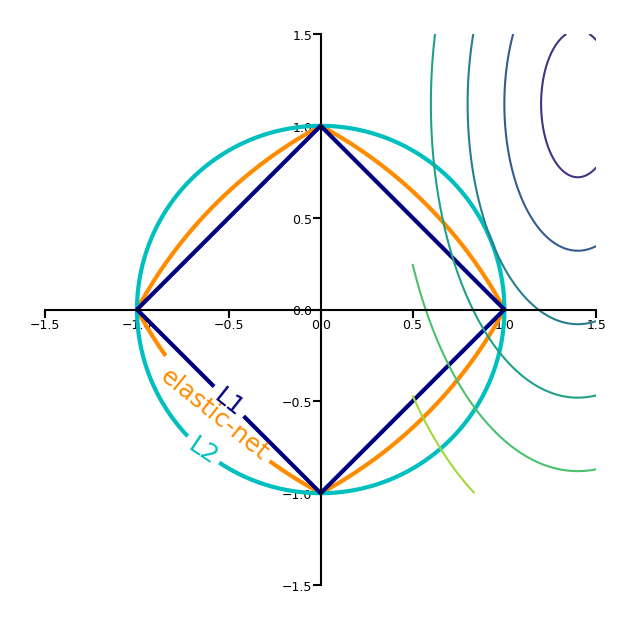

In [27]:
def plot_loss_interpretation():
    line = np.linspace(-1.5, 1.5, 1001)
    xx, yy = np.meshgrid(line, line)

    l2 = xx ** 2 + yy ** 2
    l1 = np.abs(xx) + np.abs(yy)
    rho = 0.7
    elastic_net = rho * l1 + (1 - rho) * l2

    plt.figure(figsize=(5*fig_scale, 4*fig_scale))
    ax = plt.gca()

    elastic_net_contour = plt.contour(xx, yy, elastic_net, levels=[1], linewidths=2*fig_scale, colors="darkorange")
    l2_contour = plt.contour(xx, yy, l2, levels=[1], linewidths=2*fig_scale, colors="c")
    l1_contour = plt.contour(xx, yy, l1, levels=[1], linewidths=2*fig_scale, colors="navy")
    ax.set_aspect("equal")
    ax.spines['left'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('center')
    ax.spines['top'].set_color('none')

    plt.clabel(elastic_net_contour, inline=1, fontsize=12*fig_scale,
               fmt={1.0: 'elastic-net'}, manual=[(-0.6, -0.6)])
    plt.clabel(l2_contour, inline=1, fontsize=12*fig_scale,
               fmt={1.0: 'L2'}, manual=[(-0.5, -0.5)])
    plt.clabel(l1_contour, inline=1, fontsize=12*fig_scale,
               fmt={1.0: 'L1'}, manual=[(-0.5, -0.5)])

    x1 = np.linspace(0.5, 1.5, 100)
    x2 = np.linspace(-1.0, 1.5, 100)
    X1, X2 = np.meshgrid(x1, x2)
    Y = np.sqrt(np.square(X1/2-0.7) + np.square(X2/4-0.28))
    cp = plt.contour(X1, X2, Y)
    #plt.clabel(cp, inline=1, fontsize=10)
    ax.tick_params(axis='both', pad=0)

    plt.tight_layout()
    plt.show()
plot_loss_interpretation()

### Elastic-Net

* Adds both L1 and L2 regularization:

$$\mathcal{L}_{Elastic} = \sum_{n=1}^{N} (y_n-(\mathbf{w}\mathbf{x_n} + w_0))^2 + \alpha \rho \sum_{i=1}^{p} |w_i| + \alpha (1 -  \rho) \sum_{i=1}^{p} w_i^2$$ 

* $\rho$ is the L1 ratio
    * With $\rho=1$, $\mathcal{L}_{Elastic} = \mathcal{L}_{Lasso}$
    * With $\rho=0$, $\mathcal{L}_{Elastic} = \mathcal{L}_{Ridge}$
    * $0 < \rho < 1$ sets a trade-off between L1 and L2.
* Allows learning sparse models (like Lasso) while maintaining L2 regularization benefits
    * E.g. if 2 features are correlated, Lasso likely picks one randomly, Elastic-Net keeps both 
* Weights can be optimized using coordinate descent (similar to Lasso) 

### Other loss functions for regression
* Huber loss: switches from squared loss to linear loss past a value $\epsilon$
    * More robust against outliers
* Epsilon insensitive: ignores errors smaller than $\epsilon$, and linear past that
    * Aims to fit function so that residuals are at most $\epsilon$
    * Also known as Support Vector Regression (`SVR` in sklearn)
* Squared Epsilon insensitive: ignores errors smaller than $\epsilon$, and squared past that
* These can all be solved with stochastic gradient descent
    * `SGDRegressor` in sklearn

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/huber.png" alt="ml" style="width: 500px;"/>

## Linear models for Classification
Aims to find a hyperplane that separates the examples of each class.  
For binary classification (2 classes), we aim to fit the following function: 

$\hat{y} = w_1 * x_1 + w_2 * x_2 +... + w_p * x_p + w_0 > 0$  
    
When $\hat{y}<0$, predict class -1, otherwise predict class +1

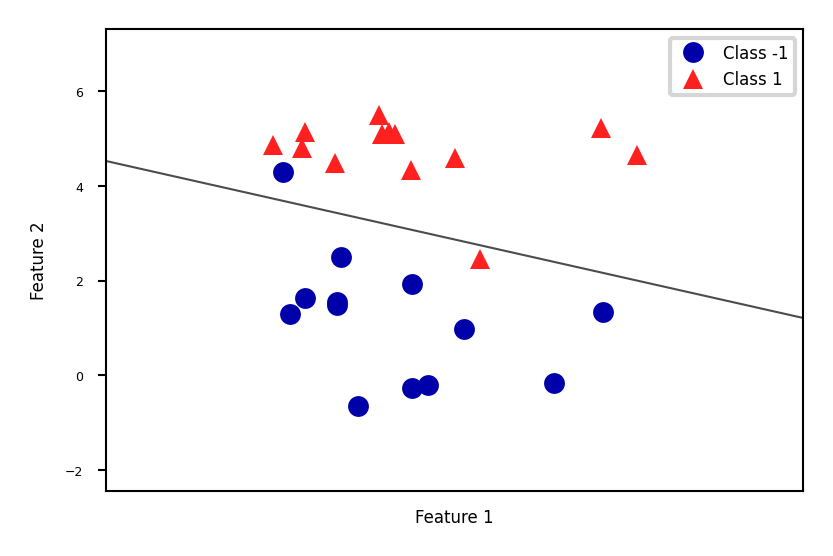

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

Xf, yf = mglearn.datasets.make_forge()
fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
clf = LogisticRegression().fit(Xf, yf)
mglearn.tools.plot_2d_separator(clf, Xf,
                                ax=ax, alpha=.7, cm=mglearn.cm2)
mglearn.discrete_scatter(Xf[:, 0], Xf[:, 1], yf, ax=ax, s=10*fig_scale)
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend(['Class -1','Class 1']);

* There are many algorithms for linear classification, differing in loss function, regularization techniques, and optimization method

* Most common techniques:
    * Convert target classes {neg,pos} to {0,1} and treat as a regression task
        * Logistic regression (Log loss)
        * Ridge Classification (Least Squares + L2 loss)
    * Find hyperplane that maximizes the margin between classes
        * Linear Support Vector Machines (Hinge loss)
    * Neural networks without activation functions
        * Perceptron (Perceptron loss)
    * SGDClassifier: can act like any of these by choosing loss function
        * Hinge, Log, Modified_huber, Squared_hinge, Perceptron

### Logistic regression
* Aims to predict the _probability_ that a point belongs to the positive class
* Converts target values {negative (blue), positive (red)} to {0,1}
* Fits a _logistic_ (or _sigmoid_ or _S_ curve) function through these points
    * Maps (-Inf,Inf) to a probability [0,1]
    
    $$ \hat{y} = \textrm{logistic}(f_{\theta}(\mathbf{x})) = \frac{1}{1+e^{-f_{\theta}(\mathbf{x})}} $$
    
* E.g. in 1D: $ \textrm{logistic}(x_1w_1+w_0) = \frac{1}{1+e^{-x_1w_1-w_0}} $

interactive(children=(FloatSlider(value=-3.0, description='w0', max=5.0, min=-10.0, step=1.0), FloatSlider(val…

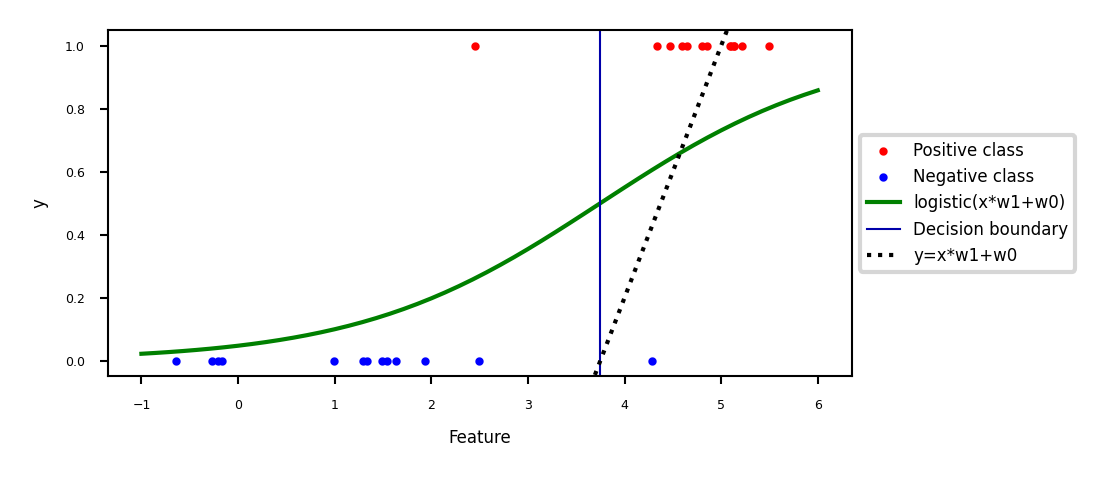

In [29]:
def sigmoid(x,w1,w0):
    return 1 / (1 + np.exp(-(x*w1+w0)))

@interact
def plot_logreg(w0=(-10.0,5.0,1),w1=(-1.0,3.0,0.3)):
    fig, ax = plt.subplots(figsize=(8*fig_scale,3*fig_scale))
    red = [Xf[i, 1] for i in range(len(yf)) if yf[i]==1]
    blue = [Xf[i, 1] for i in range(len(yf)) if yf[i]==0]
    ax.scatter(red, [1]*len(red), c='r', label='Positive class')
    ax.scatter(blue, [0]*len(blue), c='b', label='Negative class')
    x = np.linspace(min(-1, -w0/w1),max(6, -w0/w1))
    ax.plot(x,sigmoid(x,w1,w0),lw=2*fig_scale,c='g', label='logistic(x*w1+w0)'.format(np.round(w0,2),np.round(w1,2)))
    ax.axvline(x=(-w0/w1), ymin=0, ymax=1, label='Decision boundary')
    ax.plot(x,x*w1+w0,lw=2*fig_scale,c='k',linestyle=':', label='y=x*w1+w0')
    ax.set_xlabel("Feature")
    ax.set_ylabel("y")
    ax.set_ylim(-0.05,1.05)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);

In [30]:
if not interactive:
    # fitted solution
    clf2 = LogisticRegression(C=100).fit(Xf[:, 1].reshape(-1, 1), yf)
    w0 = clf2.intercept_
    w1 = clf2.coef_[0][0]
    plot_logreg(w0=w0,w1=w1)

* Fitted solution to our 2D example:
    * To get a binary prediction, choose a probability threshold (e.g. 0.5)

In [31]:
lr_clf = LogisticRegression(C=100).fit(Xf, yf)

def sigmoid2d(x1,x2,w0,w1,w2):
    return 1 / (1 + np.exp(-(x2*w2+x1*w1+w0)))

@interact
def plot_logistic_fit(rotation=(0,360,10)):
    w0 = lr_clf.intercept_
    w1 = lr_clf.coef_[0][0]
    w2 = lr_clf.coef_[0][1]

    # plot surface of f
    fig = plt.figure(figsize=(7*fig_scale,5*fig_scale))
    ax = plt.axes(projection="3d")
    x0 = np.linspace(8, 16, 30)
    x1 = np.linspace(-1, 6, 30)
    X0, X1 = np.meshgrid(x0, x1)
    
    # Surface
    ax.plot_surface(X0, X1, sigmoid2d(X0, X1, w0, w1, w2), rstride=1, cstride=1,
                    cmap='bwr', edgecolor='none',alpha=0.5,label='sigmoid')
    # Points
    c=['b','r']
    ax.scatter3D(Xf[:, 0], Xf[:, 1], yf, c=[c[i] for i in yf], s=10*fig_scale)
    
    # Decision boundary
    # x2 = -(x1*w1 + w0)/w2
    ax.plot3D(x0,-(x0*w1 + w0)/w2,[0.5]*len(x0), lw=1*fig_scale, c='k', linestyle=':')
    z = np.linspace(0, 1, 31)
    XZ, Z = np.meshgrid(x0, z)
    YZ = -(XZ*w1 + w0)/w2    
    ax.plot_wireframe(XZ, YZ, Z, rstride=5, lw=1*fig_scale, cstride=5, alpha=0.3, color='k',label='decision boundary')
    ax.tick_params(axis='both', width=0, labelsize=10*fig_scale, pad=-4)

    ax.set_xlabel('x0', labelpad=-6)
    ax.set_ylabel('x1', labelpad=-6)
    ax.get_zaxis().set_ticks([])
    ax.view_init(30, rotation) # Use this to rotate the figure
    plt.tight_layout()
    #plt.legend() # Doesn't work yet, bug in matplotlib
    plt.show()

interactive(children=(IntSlider(value=180, description='rotation', max=360, step=10), Output()), _dom_classes=…

In [32]:
if not interactive:
    plot_logistic_fit(rotation=150)

#### Loss function: Cross-entropy
* Models that return class probabilities can use _cross-entropy loss_
    
    $$\mathcal{L_{log}}(\mathbf{w}) = \sum_{n=1}^{N} H(p_n,q_n) = - \sum_{n=1}^{N} \sum_{c=1}^{C} p_{n,c} log(q_{n,c}) $$
    
    * Also known as log loss, logistic loss, or maximum likelihood
    * Based on true probabilities $p$ (0 or 1) and predicted probabilities $q$ over $N$ instances and $C$ classes
        * Binary case (C=2): $\mathcal{L_{log}}(\mathbf{w}) = - \sum_{n=1}^{N} \big[ y_n log(\hat{y}_n) + (1-y_n) log(1-\hat{y}_n) \big]$
    * Penalty (or surprise) grows exponentially as difference between $p$ and $q$ increases
    * Often used together with L2 (or L1) loss: $\mathcal{L_{log}}'(\mathbf{w}) = \mathcal{L_{log}}(\mathbf{w}) + \alpha \sum_{i} w_i^2 $


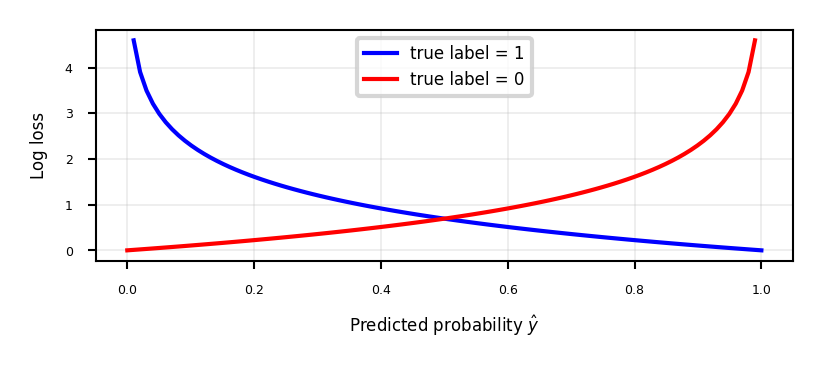

In [33]:
def cross_entropy(yHat, y):
    if y == 1:
        return -np.log(yHat)
    else:
        return -np.log(1 - yHat)

fig, ax = plt.subplots(figsize=(6*fig_scale,2*fig_scale))
x = np.linspace(0,1,100)

ax.plot(x,cross_entropy(x, 1),lw=2*fig_scale,c='b',label='true label = 1', linestyle='-')
ax.plot(x,cross_entropy(x, 0),lw=2*fig_scale,c='r',label='true label = 0', linestyle='-')
ax.set_xlabel(r"Predicted probability $\hat{y}$")
ax.set_ylabel("Log loss")
plt.grid()
plt.legend();

#### Optimization methods (solvers) for cross-entropy loss
* Gradient descent (only supports L2 regularization)
    - Log loss is differentiable, so we can use (stochastic) gradient descent
    - Variants thereof, e.g. Stochastic Average Gradient (SAG, SAGA)
* Coordinate descent (supports both L1 and L2 regularization)
    - Faster iteration, but may converge more slowly, has issues with saddlepoints
    - Called `liblinear` in sklearn. Can't run in parallel.
* Newton-Rhapson or Newton Conjugate Gradient (only L2):
    - Uses the Hessian $H = \big[\frac{\partial^2 \mathcal{L}}{\partial x_i \partial x_j} \big]$: $\mathbf{w}^{s+1} = \mathbf{w}^s-\eta H^{-1}(\mathbf{w}^s) \nabla \mathcal{L}(\mathbf{w}^s)$
    - Slow for large datasets. Works well if solution space is (near) convex
* Quasi-Newton methods (only L2)
    - Approximate, faster to compute
    - E.g. Limited-memory Broyden–Fletcher–Goldfarb–Shanno (`lbfgs`)
        - Default in sklearn for Logistic Regression
* [Some hints on choosing solvers](https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451)
    - Data scaling helps convergence, minimizes differences between solvers

#### In practice
* Logistic regression can also be found in `sklearn.linear_model`.
    * `C` hyperparameter is the _inverse_ regularization strength: $C=\alpha^{-1}$
    * `penalty`: type of regularization: L1, L2 (default), Elastic-Net, or None
    * `solver`: newton-cg, lbfgs (default), liblinear, sag, saga
* Increasing C: less regularization, tries to overfit individual points

``` python
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1).fit(X_train, y_train)
```

interactive(children=(FloatSlider(value=0.0, description='C_log', max=4.0, min=-3.0), Output()), _dom_classes=…

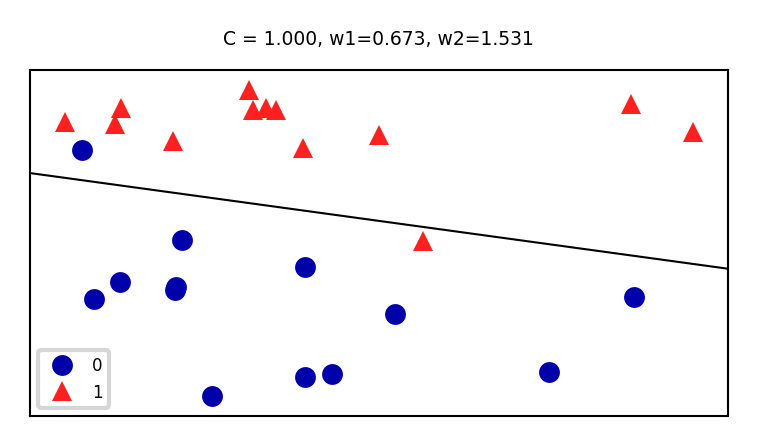

In [34]:
from sklearn.linear_model import LogisticRegression

@interact
def plot_lr(C_log=(-3,4,0.1)):
    # Still using artificial data
    fig, ax = plt.subplots(figsize=(6*fig_scale,3*fig_scale))
    mglearn.discrete_scatter(Xf[:, 0], Xf[:, 1], yf, ax=ax, s=10*fig_scale)
    lr = LogisticRegression(C=10**C_log).fit(Xf, yf)
    w = lr.coef_[0]
    xx = np.linspace(7, 13)
    yy = (-w[0] * xx - lr.intercept_[0]) / w[1]
    ax.plot(xx, yy, c='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title("C = {:.3f}, w1={:.3f}, w2={:.3f}".format(10**C_log,w[0],w[1]))
    ax.legend(loc="best");

In [35]:
if not interactive:
    plot_lr(C_log=(4))

* Analyze behavior on the breast cancer dataset
    * Underfitting if C is too small, some overfitting if C is too large
    * We use cross-validation because the dataset is small

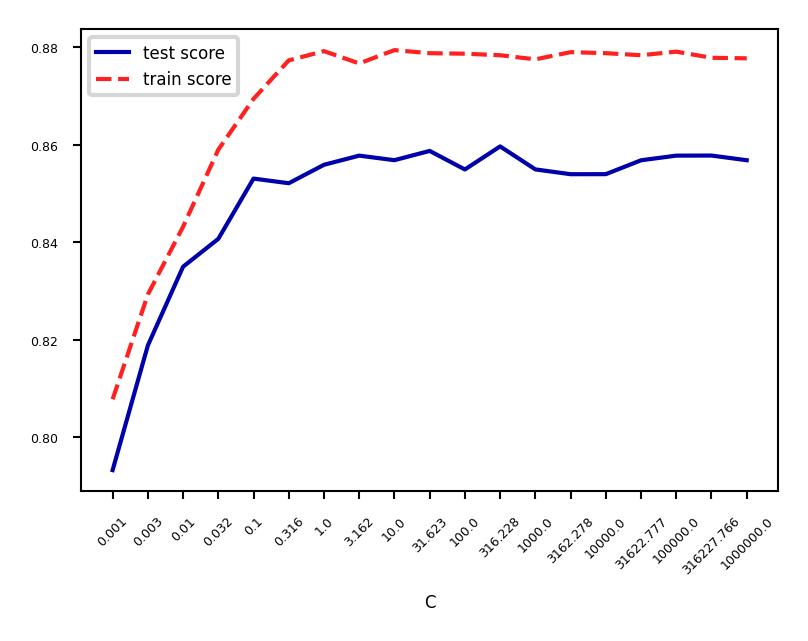

In [36]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_validate

spam_data = fetch_openml(name="qsar-biodeg", as_frame=True)
X_C, y_C = spam_data.data, spam_data.target

C=np.logspace(-3,6,num=19)
test_score=[]
train_score=[]
for c in C:
    lr = LogisticRegression(C=c)
    scores = cross_validate(lr,X_C,y_C,cv=10, return_train_score=True)
    test_score.append(np.mean(scores['test_score']))
    train_score.append(np.mean(scores['train_score']))
fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
ax.set_xticks(range(19))
ax.set_xticklabels(np.round(C,3))
ax.set_xlabel('C')
ax.plot(test_score, lw=2*fig_scale, label='test score')
ax.plot(train_score, lw=2*fig_scale, label='train score')
ax.legend()
plt.xticks(rotation=45);

* Again, choose between L1 or L2 regularization (or elastic-net)
* Small C overfits, L1 leads to sparse models

interactive(children=(FloatSlider(value=499.91, description='C', max=1000.0, min=0.01), Dropdown(description='…

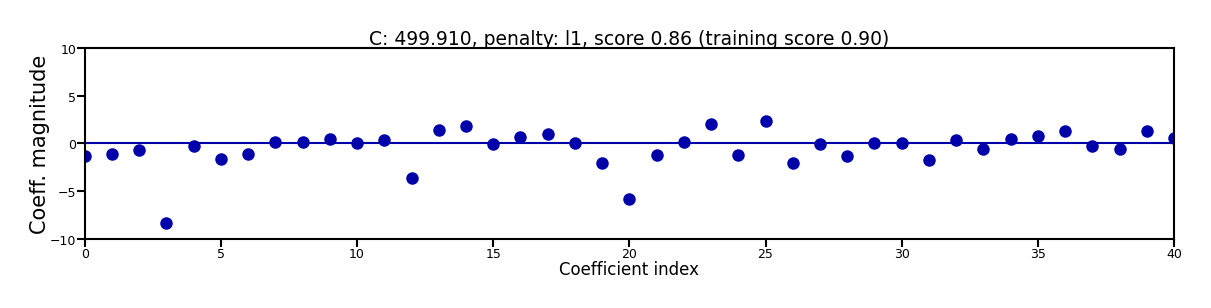

In [37]:
X_C_train, X_C_test, y_C_train, y_C_test = train_test_split(X_C, y_C, random_state=0)

@interact
def plot_logreg(C=(0.01,1000.0,0.1), penalty=['l1','l2']):
    r = LogisticRegression(C=C, penalty=penalty, solver='liblinear').fit(X_C_train, y_C_train)
    fig, ax = plt.subplots(figsize=(8*fig_scale,1.9*fig_scale))
    ax.plot(r.coef_.T, 'o', markersize=6*fig_scale)
    ax.set_title("C: {:.3f}, penalty: {}, score {:.2f} (training score {:.2f})".format(C, penalty, r.score(X_C_test, y_C_test), r.score(X_C_train, y_C_train)),pad=0)
    ax.set_xlabel("Coefficient index", labelpad=0)
    ax.set_ylabel("Coeff. magnitude", labelpad=0, fontsize=10*fig_scale)
    ax.tick_params(axis='both', pad=0)
    ax.hlines(0, 40, len(r.coef_)-1)
    ax.set_ylim(-10, 10)
    ax.set_xlim(0, 40);
    plt.tight_layout();

In [38]:
if not interactive:
    plot_logreg(0.001, 'l2')
    plot_logreg(100, 'l2')
    plot_logreg(100, 'l1')

### Ridge Classification
* Instead of log loss, we can also use ridge loss:
    
    $$\mathcal{L}_{Ridge} = \sum_{n=1}^{N} (y_n-(\mathbf{w}\mathbf{x_n} + w_0))^2 + \alpha \sum_{i=1}^{p} w_i^2$$
    
* In this case, target values {negative, positive} are converted to {-1,1}
* Can be solved similarly to Ridge regression:
    * Closed form solution (a.k.a. Cholesky)
    * Gradient descent and variants
        * E.g. Conjugate Gradient (CG) or Stochastic Average Gradient (SAG,SAGA)
    * Use Cholesky for smaller datasets, Gradient descent for larger ones


### Support vector machines
- Decision boundaries close to training points may generalize badly
    - Very similar (nearby) test point are classified as the other class
- Choose a boundary that is as far away from training points as possible
- The __support vectors__ are the training samples closest to the hyperplane
- The __margin__ is the distance between the separating hyperplane and the _support vectors_
- Hence, our objective is to _maximize the margin_
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/05_margin.png" alt="ml" style="width: 1250px;"/>

#### Solving SVMs with Lagrange Multipliers
* Imagine a hyperplane (green) $y= \sum_1^p \mathbf{w}_i * \mathbf{x}_i + w_0$ that has slope $\mathbf{w}$, value '+1' for the positive (red) support vectors, and '-1' for the negative (blue) ones
    * Margin between the boundary and support vectors is $\frac{y-w_0}{||\mathbf{w}||}$, with $||\mathbf{w}|| = \sum_i^p w_i^2$
    * We want to find the weights that maximize $\frac{1}{||\mathbf{w}||}$. We can also do that by maximizing $\frac{1}{||\mathbf{w}||^2}$
    
    
    
    

interactive(children=(IntSlider(value=10, description='rotationX', max=20), IntSlider(value=135, description='…

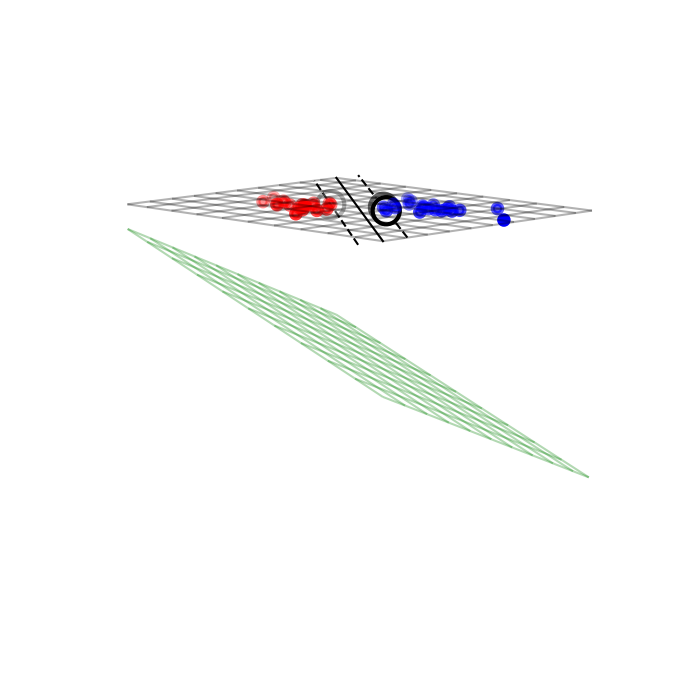

In [39]:
from sklearn.svm import SVC

# we create 40 separable points
np.random.seed(0)
sX = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]]
sY = [0] * 20 + [1] * 20

# fit the model
s_clf = SVC(kernel='linear')
s_clf.fit(sX, sY)

@interact
def plot_svc_fit(rotationX=(0,20,1),rotationY=(90,180,1)):
    # get the separating hyperplane
    w = s_clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = a * xx - (s_clf.intercept_[0]) / w[1]
    zz = np.linspace(-2, 2, 30)

    # plot the parallels to the separating hyperplane that pass through the
    # support vectors
    b = s_clf.support_vectors_[0]
    yy_down = a * xx + (b[1] - a * b[0])
    b = s_clf.support_vectors_[-1]
    yy_up = a * xx + (b[1] - a * b[0])

    # plot the line, the points, and the nearest vectors to the plane
    fig = plt.figure(figsize=(7*fig_scale,4.5*fig_scale))
    ax = plt.axes(projection="3d")
    ax.plot3D(xx, yy, [0]*len(xx), 'k-')
    ax.plot3D(xx, yy_down, [0]*len(xx), 'k--')
    ax.plot3D(xx, yy_up, [0]*len(xx), 'k--')

    ax.scatter3D(s_clf.support_vectors_[:, 0], s_clf.support_vectors_[:, 1], [0]*len(s_clf.support_vectors_[:, 0]),
                s=85*fig_scale, edgecolors='k', c='w')
    ax.scatter3D(sX[:, 0], sX[:, 1], [0]*len(sX[:, 0]), c=sY, cmap=plt.cm.bwr, s=10*fig_scale )


    # Planes
    XX, YY = np.meshgrid(xx, yy)
    if interactive:
        ZZ = w[0]*XX+w[1]*YY+clf.intercept_[0]
    else: # rescaling (for prints) messes up the Z values
        ZZ = w[0]*XX/fig_scale+w[1]*YY/fig_scale+clf.intercept_[0]*fig_scale/2
    ax.plot_wireframe(XX, YY, XX*0, rstride=5, cstride=5, alpha=0.3, color='k', label='XY plane')
    ax.plot_wireframe(XX, YY, ZZ, rstride=5, cstride=5, alpha=0.3, color='g', label='hyperplane')

    ax.set_axis_off()
    ax.view_init(rotationX, rotationY) # Use this to rotate the figure
    ax.dist = 6
    plt.tight_layout()

In [40]:
if not interactive:
    plot_svc_fit(9,135)

##### Geometric interpretation
- We want to maximize $f = \frac{1}{||w||^2}$ (blue contours)
- The hyperplane (red) must be $> 1$ for all positive examples:  
$g(\mathbf{w}) = \mathbf{w} \mathbf{x_i} + w_0 > 1 \,\,\, \forall{i}, y(i)=1$
- Find the weights $\mathbf{w}$ that satify $g$ but maximize $f$

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/LagrangeMultipliers3D.png" alt="ml" style="width: 950px;"/>

##### Solution
* A quadratic loss function with linear constraints can be solved with *Lagrangian multipliers*
* This works by assigning a weight $a_i$ (called a dual coefficient) to every data point $x_i$
    * They reflect how much individual points influence the weights $\mathbf{w}$
    * The points with non-zero $a_i$ are the _support vectors_
* Next, solve the following **Primal** objective:
    * $y_i=\pm1$ is the correct class for example $x_i$

$$\mathcal{L}_{Primal} = \frac{1}{2} ||\mathbf{w}||^2 - \sum_{i=1}^{n} a_i y_i (\mathbf{w} \mathbf{x_i}  + w_0) + \sum_{i=1}^{n} a_i $$

so that

$$ \mathbf{w} = \sum_{i=1}^{n} a_i y_i \mathbf{x_i} $$
$$ a_i \geq 0 \quad \text{and} \quad \sum_{i=1}^{l} a_i y_i = 0 $$

* It has a **Dual** formulation as well (See 'Elements of Statistical Learning' for the derivation):

$$\mathcal{L}_{Dual} = \sum_{i=1}^{l} a_i - \frac{1}{2} \sum_{i,j=1}^{l} a_i a_j y_i y_j (\mathbf{x_i} \mathbf{x_j}) $$

so that

$$ a_i \geq 0 \quad \text{and} \quad \sum_{i=1}^{l} a_i y_i = 0 $$

* Computes the dual coefficients directly. A number $l$ of these are non-zero (sparseness).
    * Dot product $\mathbf{x_i} \mathbf{x_j}$ can be interpreted as the closeness between points $\mathbf{x_i}$ and $\mathbf{x_j}$
    * $\mathcal{L}_{Dual}$ increases if nearby support vectors $\mathbf{x_i}$ with high weights $a_i$ have different class $y_i$
    * $\mathcal{L}_{Dual}$ also increases with the number of support vectors $l$ and their weights $a_i$

* Can be solved with quadratic programming, e.g. Sequential Minimal Optimization (SMO)

Example result. The circled samples are support vectors, together with their coefficients.

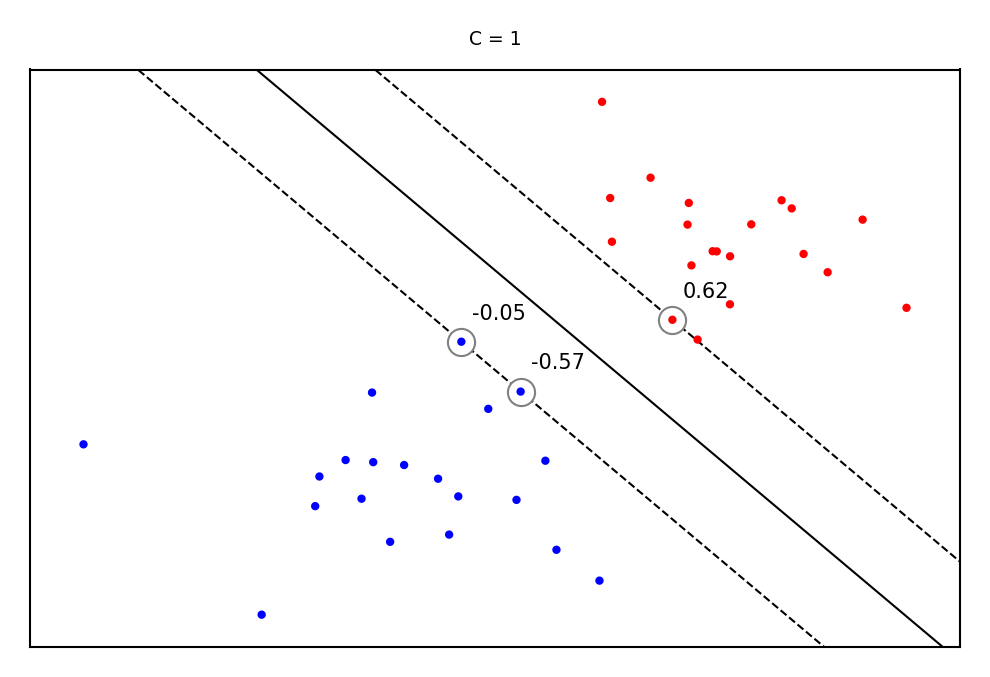

In [41]:
from sklearn.svm import SVC

# Plot SVM support vectors
def plot_linear_svm(X,y,C,ax):

    clf = SVC(kernel='linear', C=C)
    clf.fit(X, y)

    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = a * xx - (clf.intercept_[0]) / w[1]

    # plot the parallels to the separating hyperplane
    yy_down = (-1-w[0]*xx-clf.intercept_[0])/w[1]
    yy_up = (1-w[0]*xx-clf.intercept_[0])/w[1]

    # plot the line, the points, and the nearest vectors to the plane
    ax.set_title('C = %s' % C)
    ax.plot(xx, yy, 'k-')
    ax.plot(xx, yy_down, 'k--')
    ax.plot(xx, yy_up, 'k--')
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=85*fig_scale, edgecolors='gray', c='w', zorder=10, lw=1*fig_scale)
    ax.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.bwr)
    ax.axis('tight')

    # Add coefficients
    for i, coef in enumerate(clf.dual_coef_[0]):
        ax.annotate("%0.2f" % (coef), (clf.support_vectors_[i, 0]+0.1,clf.support_vectors_[i, 1]+0.35), fontsize=10*fig_scale, zorder=11)

    ax.set_xlim(np.min(X[:, 0])-0.5, np.max(X[:, 0])+0.5)
    ax.set_ylim(np.min(X[:, 1])-0.5, np.max(X[:, 1])+0.5)
    ax.set_xticks(())
    ax.set_yticks(())


# we create 40 separable points
np.random.seed(0)
svm_X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]]
svm_Y = [0] * 20 + [1] * 20
svm_fig, svm_ax = plt.subplots(figsize=(8*fig_scale,5*fig_scale))
plot_linear_svm(svm_X,svm_Y,1,svm_ax)

#### Making predictions
- $a_i$ will be *0* if the training point lies on the right side of the decision boundary and outside the margin 
- The training samples for which $a_i$ is not 0 are the _support vectors_ 
- Hence, the SVM model is completely defined by the support vectors and their dual coefficients (weights)

- Knowing the dual coefficients $a_i$, we can find the weights $w$ for the maximal margin separating hyperplane:  

$$ \mathbf{w} = \sum_{i=1}^{l} a_i y_i \mathbf{x_i} $$

- Hence, we can classify a new sample $\mathbf{u}$ by looking at the sign of $\mathbf{w}\mathbf{u}+w_0$


##### SVMs and kNN
* Remember, we will classify a new point $\mathbf{u}$ by looking at the sign of:  

$$f(x) = \mathbf{w}\mathbf{u}+w_0 = \sum_{i=1}^{l} a_i y_i \mathbf{x_i}\mathbf{u}+w_0$$

* _Weighted k-nearest neighbor_ is a generalization of the k-nearest neighbor classifier. It classifies points by evaluating:  

$$f(x) = \sum_{i=1}^{k} a_i y_i dist(x_i, u)^{-1}$$

* Hence: SVM's predict much the same way as k-NN, only:
    - They only consider the truly important points (the support vectors): _much_ faster
        - The number of neighbors is the number of support vectors
    - The distance function is an _inner product of the inputs_

#### Regularized (soft margin) SVMs

- If the data is not linearly separable, (hard) margin maximization becomes meaningless
- Relax the contraint by allowing an error $\xi_{i}$: $y_i (\mathbf{w}\mathbf{x_i} + w_0) \geq 1 - \xi_{i}$
- Or (since $\xi_{i} \geq 0$):

$$\xi_{i} =  max(0,1-y_i\cdot(\mathbf{w}\mathbf{x_i} + w_0))$$

- The sum over all points is called _hinge loss_: $\sum_i^n \xi_{i}$
- Attenuating the error component with a hyperparameter $C$, we get the objective

$$\mathcal{L}(\mathbf{w}) = ||\mathbf{w}||^2 + C \sum_i^n \xi_{i}$$

- Can still be solved with quadratic programming

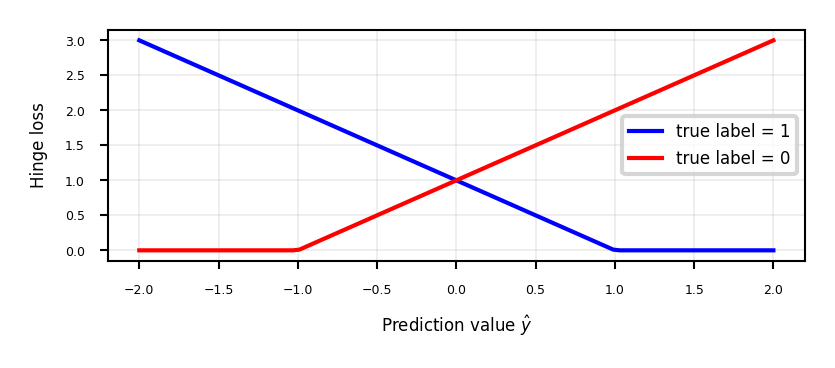

In [42]:
def hinge_loss(yHat, y):
    if y == 1:
        return np.maximum(0,1-yHat)
    else:
        return np.maximum(0,1+yHat)

fig, ax = plt.subplots(figsize=(6*fig_scale,2*fig_scale))
x = np.linspace(-2,2,100)

ax.plot(x,hinge_loss(x, 1),lw=2*fig_scale,c='b',label='true label = 1', linestyle='-')
ax.plot(x,hinge_loss(x, 0),lw=2*fig_scale,c='r',label='true label = 0', linestyle='-')
ax.set_xlabel(r"Prediction value $\hat{y}$")
ax.set_ylabel("Hinge loss")
plt.grid()
plt.legend();

#### Least Squares SVMs

- We can also use the _squares_ of all the errors, or squared hinge loss: $\sum_i^n \xi_{i}^2$
- This yields the Least Squares SVM objective

$$\mathcal{L}(\mathbf{w}) = ||\mathbf{w}||^2 + C \sum_i^n \xi_{i}^2$$

- Can be solved with Lagrangian Multipliers and a set of linear equations
    - Still yields support vectors and still allows kernelization
    - Support vectors are not sparse, but pruning techniques exist

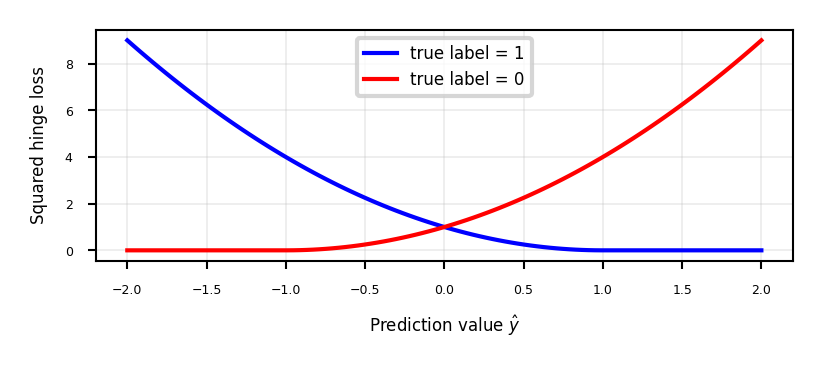

In [43]:
fig, ax = plt.subplots(figsize=(6*fig_scale,2*fig_scale))
x = np.linspace(-2,2,100)

ax.plot(x,hinge_loss(x, 1)** 2,lw=2*fig_scale,c='b',label='true label = 1', linestyle='-')
ax.plot(x,hinge_loss(x, 0)** 2,lw=2*fig_scale,c='r',label='true label = 0', linestyle='-')
ax.set_xlabel(r"Prediction value $\hat{y}$")
ax.set_ylabel("Squared hinge loss")
plt.grid()
plt.legend();

#### Effect of regularization on margin and support vectors
- SVM's Hinge loss acts like L1 regularization, yields sparse models
- C is the _inverse_ regularization strength (inverse of $\alpha$ in Lasso)
    - Larger C: fewer support vectors, smaller margin, more overfitting
    - Smaller C: more support vectors, wider margin, less overfitting
- Needs to be tuned carefully to the data

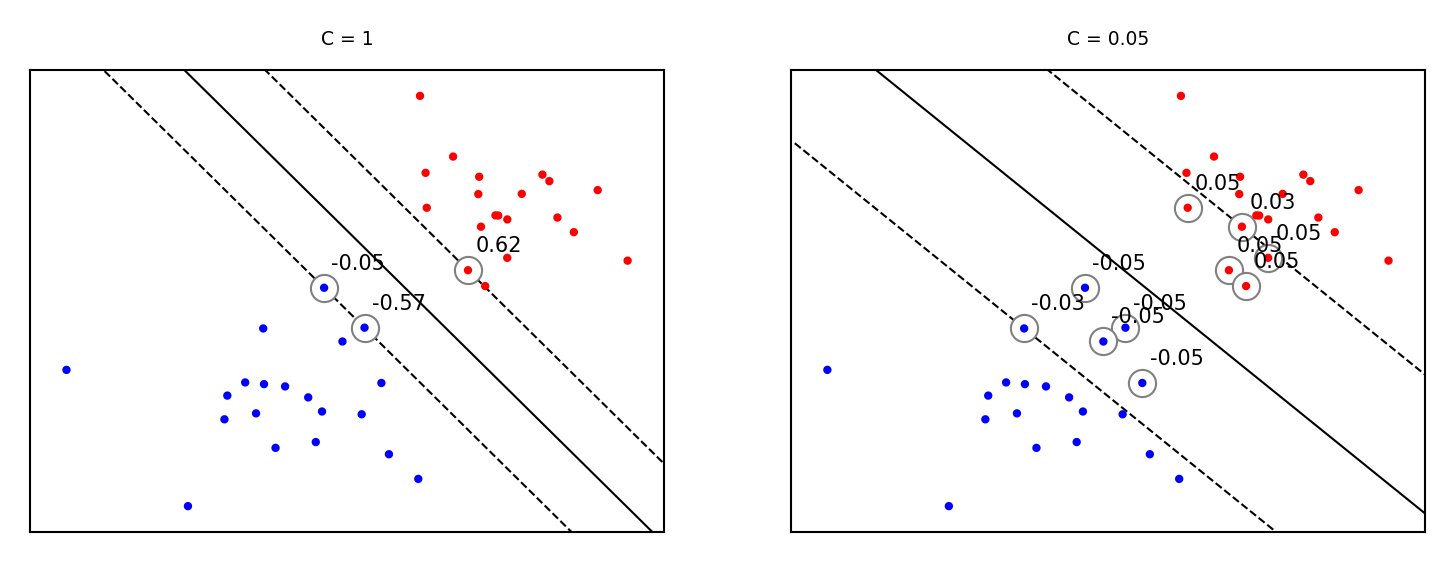

In [44]:
fig, svm_axes = plt.subplots(nrows=1, ncols=2, figsize=(12*fig_scale, 4*fig_scale))
plot_linear_svm(svm_X,svm_Y,1,svm_axes[0])
plot_linear_svm(svm_X,svm_Y,0.05,svm_axes[1])

Same for non-linearly separable data

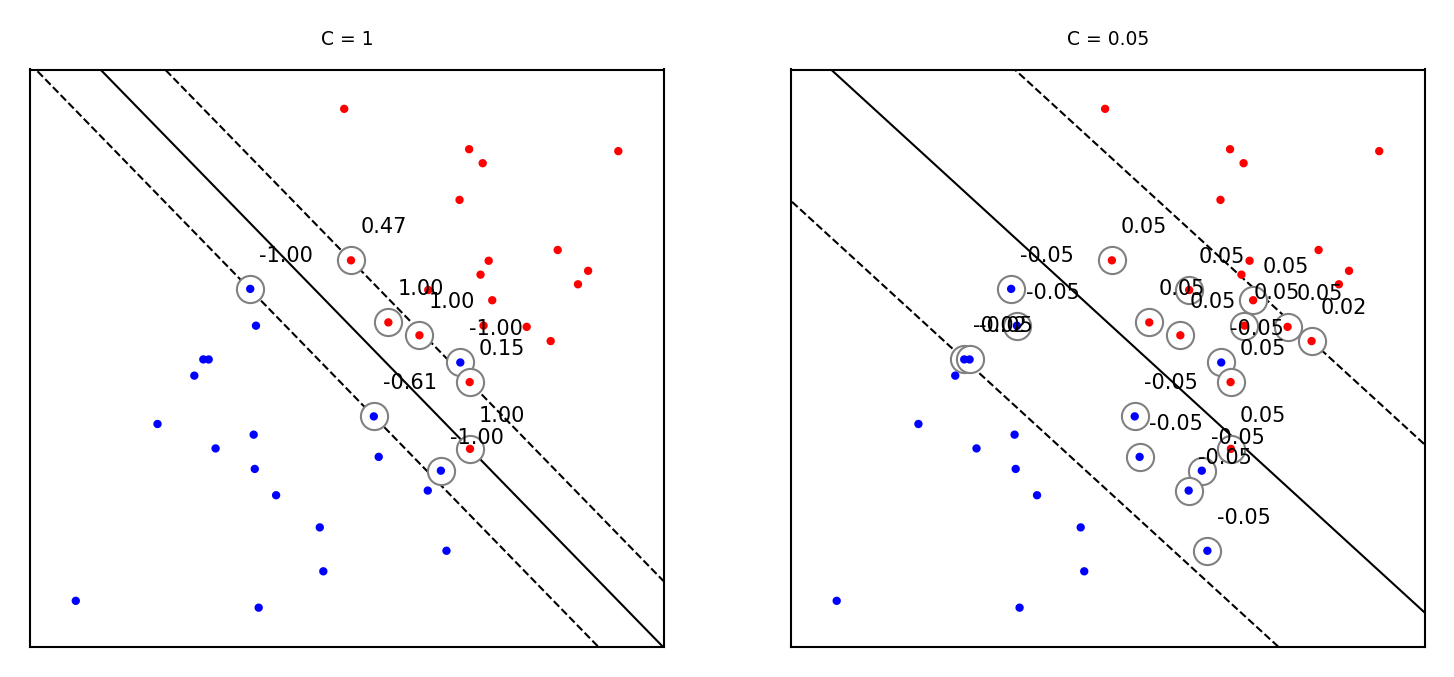

In [45]:
svm_X = np.r_[np.random.randn(20, 2) - [1, 1], np.random.randn(20, 2) + [1, 1]]
fig, svm_axes = plt.subplots(nrows=1, ncols=2, figsize=(12*fig_scale, 5*fig_scale))
plot_linear_svm(svm_X,svm_Y,1,svm_axes[0])
plot_linear_svm(svm_X,svm_Y,0.05,svm_axes[1])

Large C values can lead to overfitting (e.g. fitting noise), small values can lead to underfitting

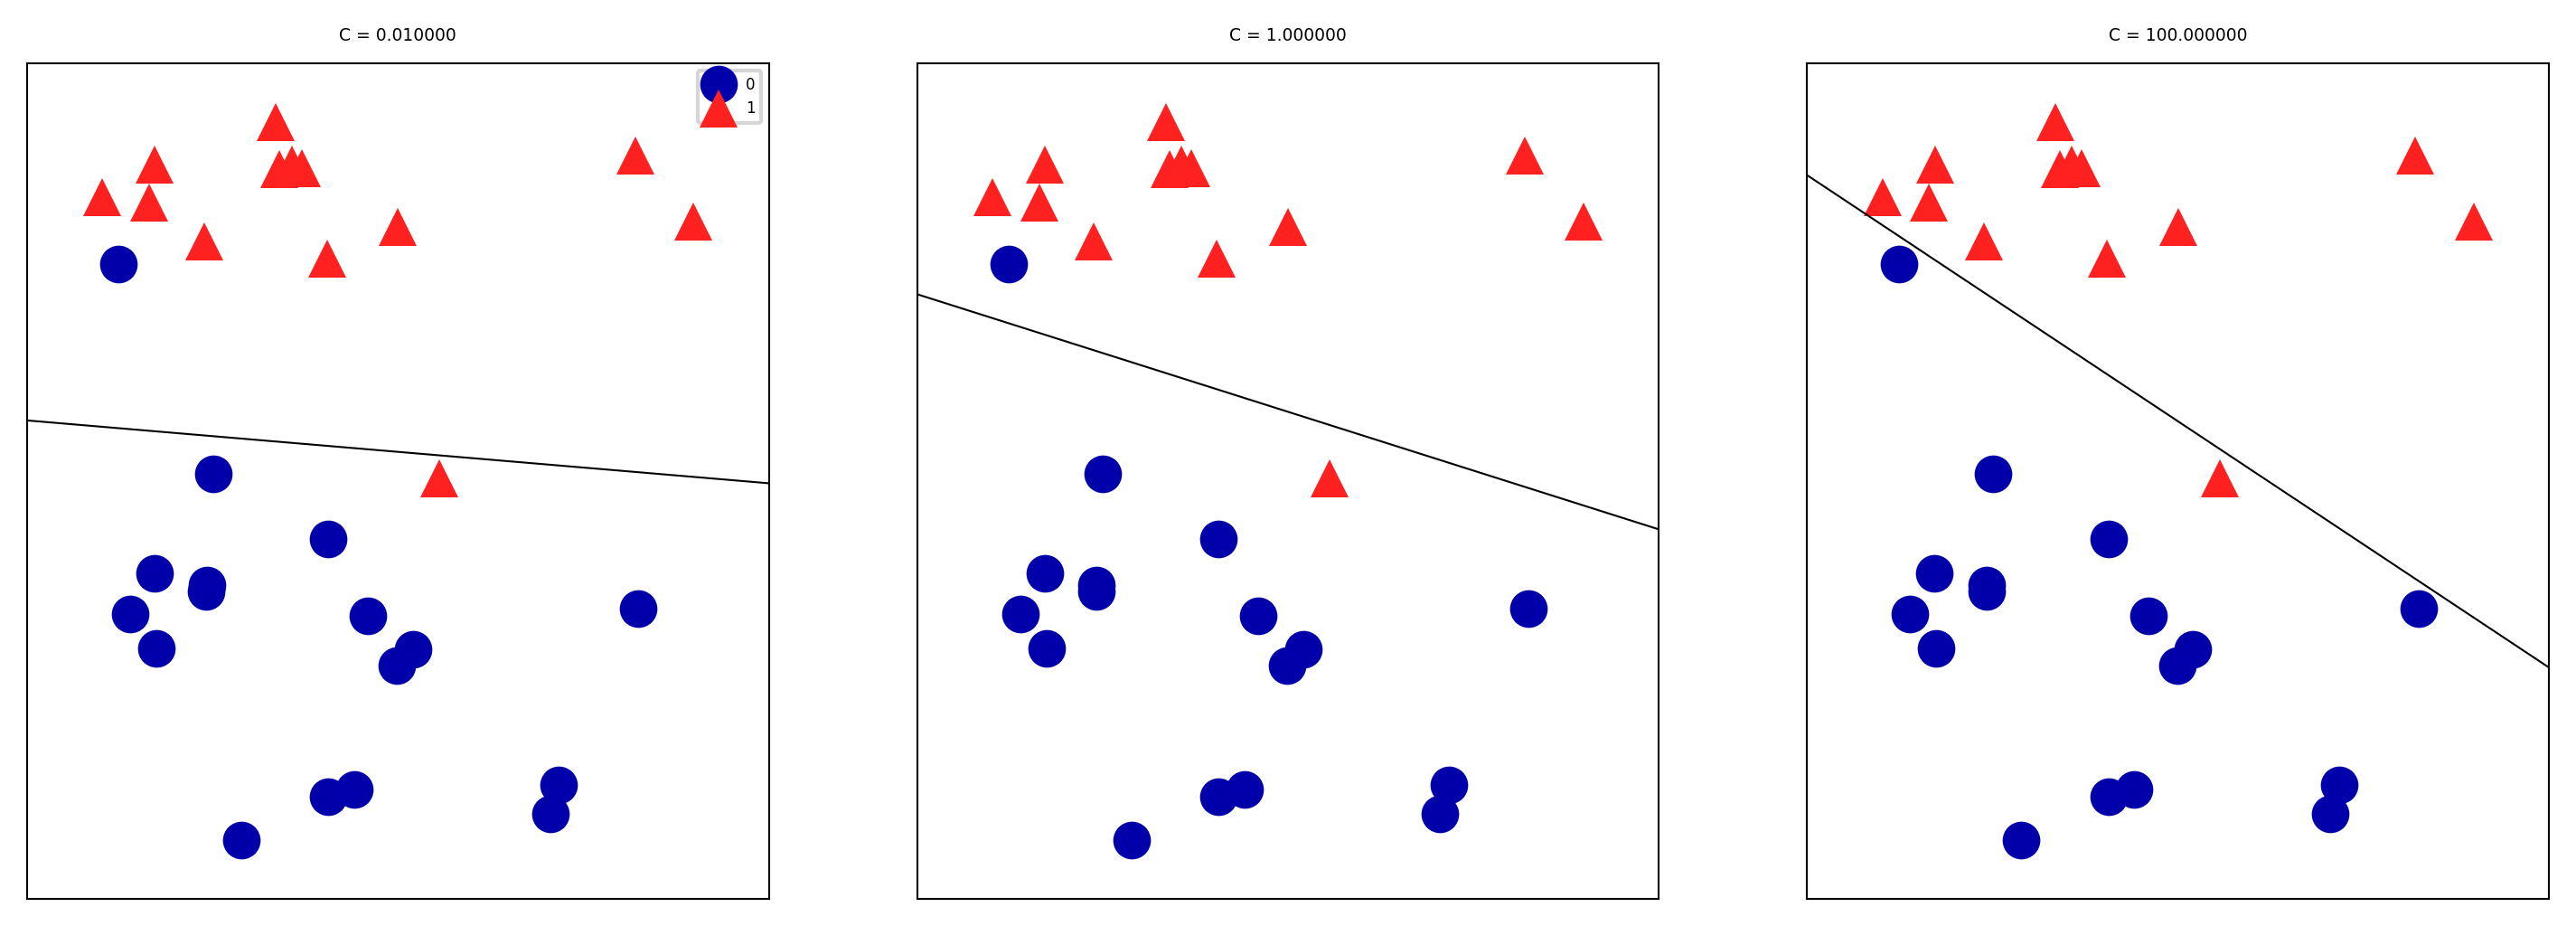

In [46]:
mglearn.plots.plot_linear_svc_regularization()

#### SVMs in scikit-learn

- `svm.LinearSVC`: faster for large datasets
    - Allows choosing between the primal or dual. Primal recommended when $n$ >> $p$
    - Returns `coef_` ($\mathbf{w}$) and `intercept_` ($w_0$)
- `svm.SVC` with `kernel=linear`: allows _kernelization_ (see later)
    - Also returns `support_vectors_` (the support vectors) and the `dual_coef_` $a_i$
    - Scales at least quadratically with the number of samples $n$
- `svm.LinearSVR` and `svm.SVR` are variants for regression
``` python
clf = svm.SVC(kernel='linear')
clf.fit(X, Y)
print("Support vectors:", clf.support_vectors_[:])
print("Coefficients:", clf.dual_coef_[:])
```

In [47]:
from sklearn import svm

# Linearly separable dat
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]]
Y = [0] * 20 + [1] * 20

# Fit the model
clf = svm.SVC(kernel='linear')
clf.fit(X, Y)

# Get the support vectors and weights
print("Support vectors:")
print(clf.support_vectors_[:])
print("Coefficients:")
print(clf.dual_coef_[:])

Support vectors:
[[-1.021  0.241]
 [-0.467 -0.531]
 [ 0.951  0.58 ]]
Coefficients:
[[-0.048 -0.569  0.617]]


#### Solving SVMs with Gradient Descent
* Soft-margin SVMs can, alternatively, be solved using gradient decent
    * Good for large datasets, but does not yield support vectors or kernelization
* Squared Hinge is differentiable
* Hinge is not differentiable but convex, and has a subgradient:

$$\mathcal{L_{Hinge}}(\mathbf{w}) =  max(0,1-y_i (\mathbf{w}\mathbf{x_i} + w_0))$$

$$\frac{\partial \mathcal{L_{Hinge}}}{\partial w_i} =  \begin{cases}-y_i x_i & y_i (\mathbf{w}\mathbf{x_i} + w_0) < 1\\ 0 & \text{otherwise} \\ \end{cases}$$

* Can be solved with (stochastic) gradient descent

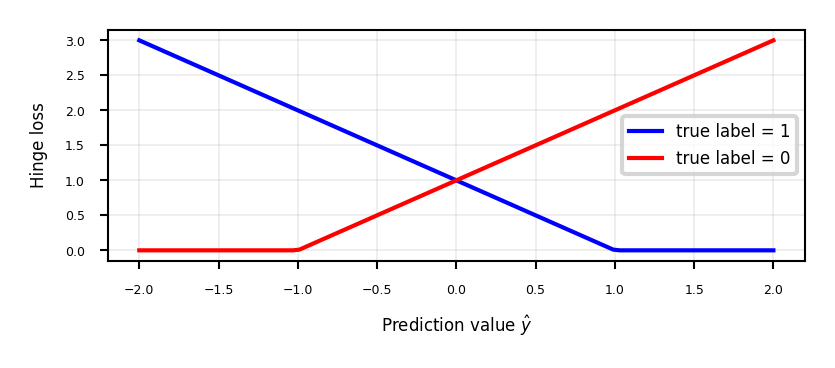

In [48]:
fig, ax = plt.subplots(figsize=(6*fig_scale,2*fig_scale))
x = np.linspace(-2,2,100)

ax.plot(x,hinge_loss(x, 1),lw=2*fig_scale,c='b',label='true label = 1', linestyle='-')
ax.plot(x,hinge_loss(x, 0),lw=2*fig_scale,c='r',label='true label = 0', linestyle='-')
ax.set_xlabel(r"Prediction value $\hat{y}$")
ax.set_ylabel("Hinge loss")
plt.grid()
plt.legend();

#### Generalized SVMs
* Because the derivative of hinge loss is undefined at y=1, smoothed versions are often used:
    * Squared hinge loss: yields _least squares SVM_
        - Equivalent to Ridge classification (with different solver)
    * Modified Huber loss: squared hinge, but linear after -1. Robust against outliers
* Log loss can also be used (equivalent to logistic regression) 
* In sklearn, `SGDClassifier` can be used with any of these. Good for large datasets.

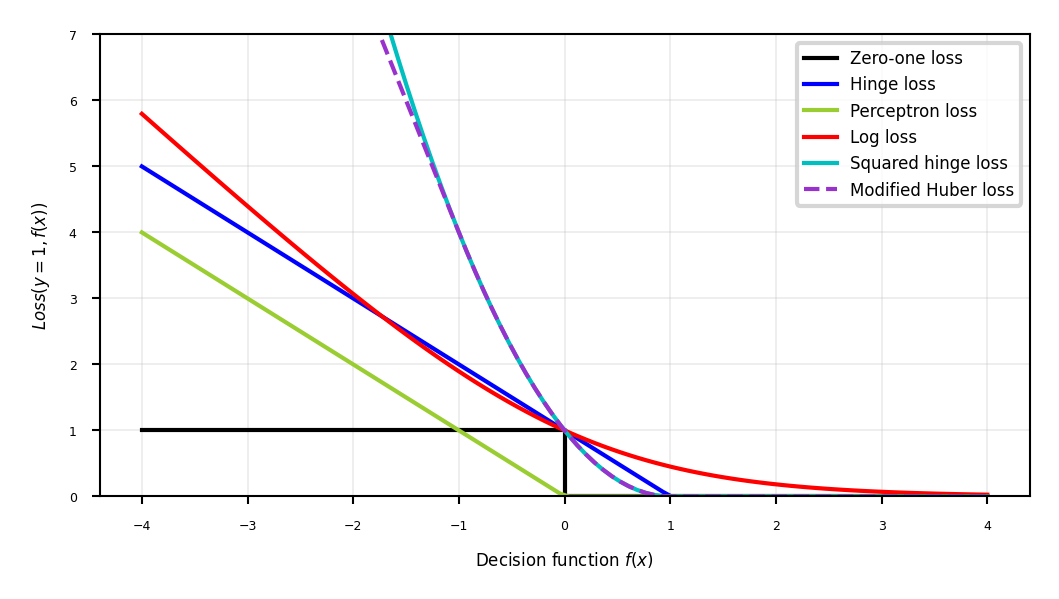

In [49]:
def modified_huber_loss(y_true, y_pred):
    z = y_pred * y_true
    loss = -4 * z
    loss[z >= -1] = (1 - z[z >= -1]) ** 2
    loss[z >= 1.] = 0
    return loss

xmin, xmax = -4, 4
xx = np.linspace(xmin, xmax, 100)
lw = 2*fig_scale
fig, ax = plt.subplots(figsize=(8*fig_scale,4*fig_scale))
plt.plot([xmin, 0, 0, xmax], [1, 1, 0, 0], 'k-', lw=lw,
         label="Zero-one loss")
plt.plot(xx, np.where(xx < 1, 1 - xx, 0), 'b-', lw=lw,
         label="Hinge loss")
plt.plot(xx, -np.minimum(xx, 0), color='yellowgreen', lw=lw,
         label="Perceptron loss")
plt.plot(xx, np.log2(1 + np.exp(-xx)), 'r-', lw=lw,
         label="Log loss")
plt.plot(xx, np.where(xx < 1, 1 - xx, 0) ** 2, 'c-', lw=lw,
         label="Squared hinge loss")
plt.plot(xx, modified_huber_loss(xx, 1), color='darkorchid', lw=lw,
         linestyle='--', label="Modified Huber loss")
plt.ylim((0, 7))
plt.legend(loc="upper right")
plt.xlabel(r"Decision function $f(x)$")
plt.ylabel("$Loss(y=1, f(x))$")
plt.grid()
plt.legend();

### Perceptron
* Represents a single neuron (node) with inputs $x_i$, a bias $w_0$, and output $y$
* Each connection has a (synaptic) weight $w_i$. The node outputs $\hat{y} = \sum_{i}^n x_{i}w_i + w_0$
* The _activation function_ predicts 1 if $\mathbf{xw} + w_0 > 0$, -1 otherwise
* Weights can be learned with (stochastic) gradient descent and Hinge(0) loss
    * Updated _only_ on misclassification, corrects output by $\pm1$
    
    $$\mathcal{L}_{Perceptron} = max(0,-y_i (\mathbf{w}\mathbf{x_i} + w_0))$$
    
    $$\frac{\partial \mathcal{L_{Perceptron}}}{\partial w_i} =  \begin{cases}-y_i x_i & y_i (\mathbf{w}\mathbf{x_i} + w_0) < 0\\ 0 & \text{otherwise} \\ \end{cases}$$
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/perceptron.png" alt="ml" style="margin: 0 auto; width: 1500px;"/>

## Linear Models for multiclass classification
### one-vs-rest (aka one-vs-all)

* Learn a binary model for each class vs. all other classes
* Create as many binary models as there are classes

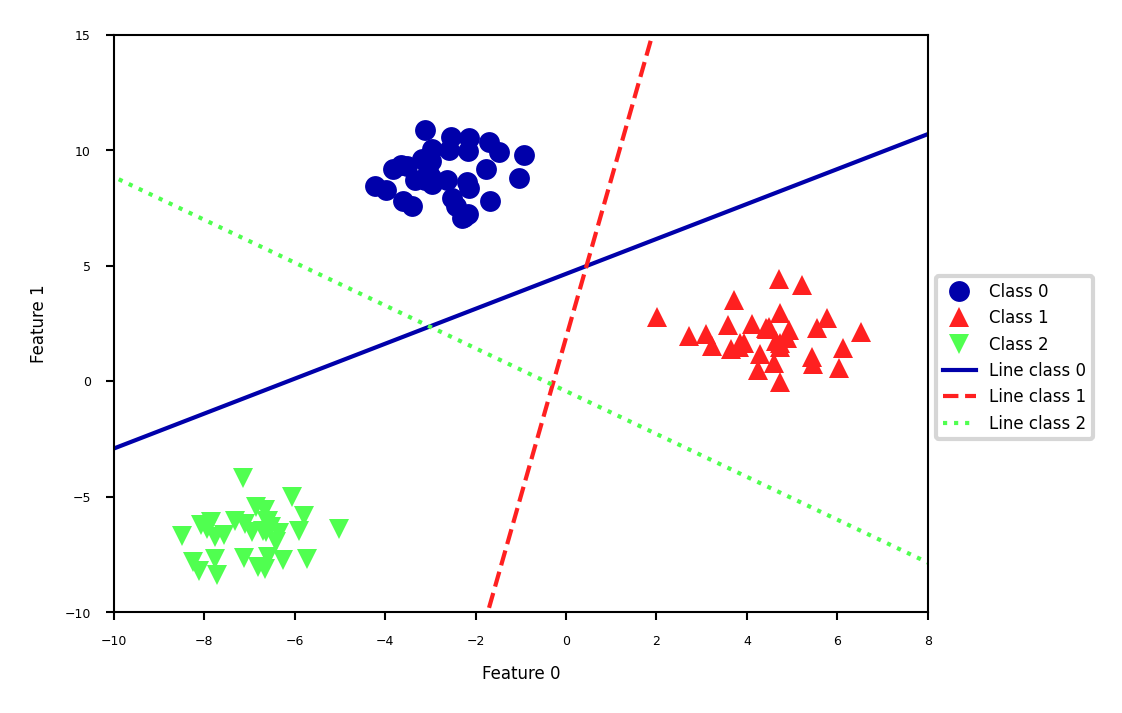

In [50]:
from sklearn.datasets import make_blobs

X, y = make_blobs(random_state=42)
linear_svm = LinearSVC().fit(X, y)

plt.rcParams["figure.figsize"] = (7*fig_scale,5*fig_scale)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y, s=10*fig_scale)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_,
                                  mglearn.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color, lw=2*fig_scale)
plt.ylim(-10, 15)
plt.xlim(-10, 8)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1',
            'Line class 2'], loc=(1.01, 0.3));

* Every binary classifiers makes a prediction, the one with the highest score (>0) wins

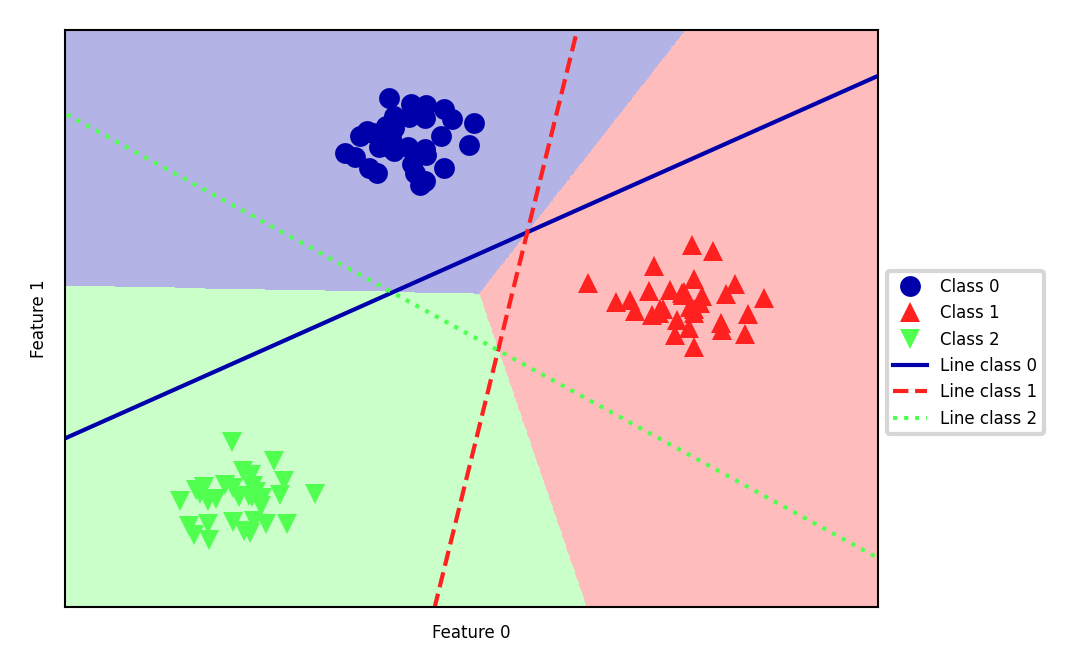

In [51]:
mglearn.plots.plot_2d_classification(linear_svm, X, fill=True, alpha=0.3)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y, s=10*fig_scale)
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_,
                                  mglearn.cm3.colors):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color, lw=2*fig_scale)
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1',
            'Line class 2'], loc=(1.01, 0.3))
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

### one-vs-one
* An alternative is to learn a binary model for every _combination_ of two classes
    * For $C$ classes, this results in $\frac{C(C-1)}{2}$ binary models
    * Each point is classified according to a majority vote amongst all models
    * Can also be a 'soft vote': sum up the probabilities (or decision values) for all models. The class with the highest sum wins.
* Requires more models than one-vs-rest, but training each one is faster
    * Only the examples of 2 classes are included in the training data
* Recommended for algorithms than learn well on small datasets 
    * Especially SVMs and Gaussian Processes

In [52]:
%%HTML
<style>
td {font-size: 16px}
th {font-size: 16px}
.rendered_html table, .rendered_html td, .rendered_html th {
    font-size: 16px;
}
</style>

## Linear models overview

| Name | Representation | Loss function | Optimization | Regularization |
|---|---|---|---|---|
| Least squares    | Linear function (R) | SSE | CFS or SGD | None |
| Ridge | Linear function (R) | SSE + L2 | CFS or SGD | L2 strength ($\alpha$)  |
| Lasso | Linear function (R) | SSE + L1 | Coordinate descent   | L1 strength ($\alpha$)  |
| Elastic-Net | Linear function (R) | SSE + L1 + L2 | Coordinate descent   | $\alpha$, L1 ratio ($\rho$)  |
| SGDRegressor | Linear function (R) | SSE, Huber, $\epsilon$-ins,... + L1/L2 | SGD   | L1/L2, $\alpha$  |
| Logistic regression | Linear function (C) | Log + L1/L2 | SGD, coordinate descent,...   | L1/L2, $\alpha$ |
| Ridge classification | Linear function (C) | SSE + L2 | CFS or SGD   | L2 strength ($\alpha$) |
| Linear SVM | Support Vectors | Hinge(1) | Quadratic programming or SGD | Cost (C) |
| Least Squares SVM | Support Vectors | Squared Hinge | Linear equations or SGD | Cost (C) |
| Perceptron | Linear function (C) | Hinge(0) | SGD | None |
| SGDClassifier | Linear function (C) | Log, (Sq.) Hinge, Mod. Huber,... | SGD | L1/L2, $\alpha$ |

* SSE: Sum of Squared Errors
* CFS: Closed-form solution
* SGD: (Stochastic) Gradient Descent and variants
* (R)egression, (C)lassification

## Summary

- Linear models
    - Good for very large datasets (scalable)
    - Good for very high-dimensional data (not for low-dimensional data)
- Can be used to fit non-linear or low-dim patterns as well (see later)
    - Preprocessing: e.g. Polynomial or Poisson transformations
    - Generalized linear models (kernelization)
- Regularization is important. Tune the regularization strength ($\alpha$)
    - Ridge (L2): Good fit, sometimes sensitive to outliers
    - Lasso (L1): Sparse models: fewer features, more interpretable, faster
    - Elastic-Net: Trade-off between both, e.g. for correlated features 
- Most can be solved by different optimizers (solvers)
    - Closed form solutions or quadratic/linear solvers for smaller datasets
    - Gradient descent variants (SGD,CD,SAG,CG,...) for larger ones
- Multi-class classification can be done using a one-vs-all approach